<a href="https://colab.research.google.com/github/lim1004567/AICV03_SEM_3D_METROLOGY/blob/main/MMT_S_bestpt_%EC%84%B1%EB%8A%A5%EA%B0%9C%EC%84%A01_%EA%B8%B0%EB%B0%98_%EC%A7%80%EC%8B%9D%EC%A6%9D%EB%A5%98_%EA%B2%BD%EB%9F%89%ED%99%941.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 지식증류 경량화란
거대하고 복잡한 고성능 모델(Teacher, 교사)이 학습한 지식과 패턴을 작고 가벼운 모델(Student, 학생)로 전이하여, 모델의 크기와 연산량을 줄이면서도 성능을 높게 유지하는 AI 모델 압축 기술

# 지식 증류 경량화를 위해서 학습 전까지 전처리를 9. DL 학습/평가 함수까지 MMT-S 성능개선1에 있는 그대로 가져옴

# 1. 환경 설정 및 라이브러리 Import (베이스라인)

In [ ]:
# 라이브러리 Install
!pip install -q catboost xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 26.7 MB/s eta 0:00:00


In [ ]:
# ======================================================================
#  OHT 열화 예측 — MultiModal Transformer (MMT) 구현
#
#  목적: 반도체 공장 내 OHT(Overhead Hoist Transport) 장비의 열화 상태를
#        열화상 이미지 + 센서 시계열 데이터로 예측하는 멀티모달 모델 구현.
#
#  데이터: AI Hub "지능형 물류 반송 장비 고장 예지 데이터"
#         - 18대 OHT 장비, 8종 센서(PM10/PM2.5/PM1.0/NTC/CT1~4)
#         - 120x160 열화상 바이너리 이미지
#         - 4등급 라벨: 0(정상), 1(관심), 2(경고), 3(위험)
#
#  모델 구성:
#    ML  — RandomForest, XGBoost, LightGBM, CatBoost
#    DL  — CNN(RegNet), LSTM, CNN+LSTM, MMT-S/B/L
#
#  평가: RMSE(회귀), Macro F1, Macro Recall
#  분할: 장비 01~14(Train) / 15~16(Val) / 17~18(Test)
# ======================================================================

# -- 기본 라이브러리 --
import os, glob, json, time, math, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm.auto import tqdm

# -- PyTorch --
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as tv_models

# -- scikit-learn (전처리 및 평가) --
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, recall_score, mean_squared_error,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
)
from sklearn.ensemble import RandomForestClassifier

# -- Gradient Boosting 라이브러리 --
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

# ======================================================================
#  GPU 확인
# ======================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"✅ GPU: {gpu_name} ({gpu_mem:.1f} GB)")
else:
    print("⚠️ GPU 미감지 — CPU 모드")

# ======================================================================
#  wandb (Weights & Biases)
#
#  wandb가 하는 일:
#    - 학습 중 loss, lr, F1 등 메트릭을 실시간으로 웹 대시보드에 기록
#    - 모델별 하이퍼파라미터와 성능을 한눈에 비교
#    - confusion matrix, gradient 등을 자동 시각화
#
#  Colab Secrets에 WANDB_API_KEY 저장 필요:
#    좌측 🔑 아이콘 -> WANDB_API_KEY -> wandb.ai에서 발급받은 키 입력
# ======================================================================

import wandb
from google.colab import userdata

try:
    wandb_key = userdata.get('WANDB_API_KEY')
    wandb.login(key=wandb_key)
    WANDB_ENABLED = True
    print("✅ wandb 로그인 성공")
except Exception as e:
    print(f"⚠️ wandb 로그인 실패: {e} — 로컬 로깅만 사용")
    WANDB_ENABLED = False

# ======================================================================
#  캐시 디렉토리
#  시간이 오래 걸리는 작업(압축 해제, 피처 추출, 학습 등)의 결과를
#  pickle/npz 파일로 저장해두고, 재실행 시 즉시 로드하여 시간을 절약
# ======================================================================

CACHE_DIR = '/content/_cache'
os.makedirs(CACHE_DIR, exist_ok=True)

print(f"✅ 환경 설정 완료  |  Device: {device}  |  wandb: {WANDB_ENABLED}")

✅ GPU: NVIDIA A100-SXM4-40GB (39.5 GB)
⚠️ wandb 로그인 실패: Secret WANDB_API_KEY does not exist. — 로컬 로깅만 사용
✅ 환경 설정 완료  |  Device: cuda  |  wandb: False


# 2. Google Drive 마운트 & 데이터 압축 해제 (Training + Validation) (베이스라인)

In [ ]:
# ======================================================================
#  Google Drive에서 ZIP 파일을 로컬 디스크로 복사 후 압축 해제
#
#  데이터 구조:
#    Drive/.../Training/01.원천데이터/  -> .bin (열화상 이미지)
#    Drive/.../Training/02.라벨링데이터/ -> .json (센서 + 라벨)
#    Drive/.../Validation/01.원천데이터/ -> .bin
#    Drive/.../Validation/02.라벨링데이터/ -> .json
#
#  로컬 저장 경로:
#    /content/training/source/   -> Training BIN 파일들
#    /content/training/label/    -> Training JSON 파일들
#    /content/validation/source/ -> Validation BIN 파일들
#    /content/validation/label/  -> Validation JSON 파일들
#
#  왜 로컬로 복사하는가:
#    Drive에서 직접 ZIP 해제하면 I/O 병목으로 매우 느림.
#    ZIP을 로컬(/content)로 먼저 복사 후 해제하면 좀 더 빠름.
# ======================================================================

from google.colab import drive
import zipfile, shutil

drive.mount('/content/drive')

# -- 경로 설정 --
data_path = '/content/drive/MyDrive/dataset/3.개방데이터/1.데이터'

# Training: OHT&AGV 01~16번 장비 데이터 (학습 + 검증용)
base_path_train      = os.path.join(data_path, 'Training')
source_zip_dir_train = os.path.join(base_path_train, '01.원천데이터')
label_zip_dir_train  = os.path.join(base_path_train, '02.라벨링데이터')

# Validation: OHT&AGV 17~18번 장비 데이터 (최종 테스트용)
base_path_val        = os.path.join(data_path, 'Validation')
source_zip_dir_val   = os.path.join(base_path_val, '01.원천데이터')
label_zip_dir_val    = os.path.join(base_path_val, '02.라벨링데이터')

# 로컬 저장 경로
local_train_source = '/content/training/source'
local_train_label  = '/content/training/label'
local_val_source   = '/content/validation/source'
local_val_label    = '/content/validation/label'
local_zip_cache    = '/content/_zip_cache'   # ZIP 임시 복사 폴더


def extract_via_local(zip_dir, extract_to):
    """
    Drive의 ZIP 파일을 로컬로 복사 후 압축 해제.

    과정:
      1. Drive에서 ZIP 파일 목록 확인
      2. 각 ZIP을 로컬 임시 폴더로 복사
      3. 로컬에서 압축 해제 (Drive I/O 병목 회피)
      4. 임시 ZIP 파일 삭제

    Args:
        zip_dir:    Drive 내 ZIP 파일이 있는 디렉토리
        extract_to: 압축 해제할 로컬 디렉토리
    """
    os.makedirs(extract_to, exist_ok=True)
    os.makedirs(local_zip_cache, exist_ok=True)
    zip_files = sorted([f for f in os.listdir(zip_dir) if f.endswith('.zip')])
    print(f"  {len(zip_files)}개 zip 발견 -> 로컬 복사 후 해제")
    for zf in tqdm(zip_files, desc="  Extract"):
        src = os.path.join(zip_dir, zf)       # Drive 경로
        dst = os.path.join(local_zip_cache, zf) # 로컬 임시 경로
        if not os.path.exists(dst):
            shutil.copy2(src, dst)             # Drive -> 로컬 복사
        try:
            with zipfile.ZipFile(dst, 'r') as z:
                z.extractall(extract_to)       # 로컬에서 해제
        except Exception as e:
            print(f"    ⚠️ {zf} 실패: {e}")
    shutil.rmtree(local_zip_cache, ignore_errors=True)  # 임시 ZIP 삭제


def count_files(directory, ext):
    """디렉토리 내 특정 확장자 파일 수 카운트"""
    if os.path.exists(directory):
        return len(glob.glob(os.path.join(directory, f'*.{ext}')))
    return 0

# ======================================================================
#  Training 데이터 압축 해제
#  이미 해제된 경우(파일 수 >= 99,000) 스킵
# ======================================================================

train_bin_count  = count_files(local_train_source, 'bin')
train_json_count = count_files(local_train_label, 'json')

if train_bin_count >= 99000 and train_json_count >= 99000:
    print("✅ [Training] 이미 압축 해제됨 — 스킵")
else:
    print("📦 [Training] 압축 해제 시작...")
    extract_via_local(source_zip_dir_train, local_train_source)
    extract_via_local(label_zip_dir_train, local_train_label)
    train_bin_count  = count_files(local_train_source, 'bin')
    train_json_count = count_files(local_train_label, 'json')
    print("  ✅ Training 압축 해제 완료!")

print(f"  Training BIN:  {train_bin_count:,}개")
print(f"  Training JSON: {train_json_count:,}개")

# ======================================================================
#  Validation 데이터 압축 해제
#  이미 해제된 경우(파일 수 >= 10,000) 스킵
# ======================================================================

val_bin_count  = count_files(local_val_source, 'bin')
val_json_count = count_files(local_val_label, 'json')

if val_bin_count >= 10000 and val_json_count >= 10000:
    print("\n✅ [Validation] 이미 압축 해제됨 — 스킵")
else:
    print("\n📦 [Validation] 압축 해제 시작...")
    extract_via_local(source_zip_dir_val, local_val_source)
    extract_via_local(label_zip_dir_val, local_val_label)
    val_bin_count  = count_files(local_val_source, 'bin')
    val_json_count = count_files(local_val_label, 'json')
    print("  ✅ Validation 압축 해제 완료!")

print(f"  Validation BIN:  {val_bin_count:,}개")
print(f"  Validation JSON: {val_json_count:,}개")

print(f"\n✅ 전체 데이터: BIN {train_bin_count + val_bin_count:,}개, "
      f"JSON {train_json_count + val_json_count:,}개")

Mounted at /content/drive
📦 [Training] 압축 해제 시작...
  303개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/303 [00:00<?, ?it/s]

  303개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/303 [00:00<?, ?it/s]

  ✅ Training 압축 해제 완료!
  Training BIN:  99,476개
  Training JSON: 99,476개

📦 [Validation] 압축 해제 시작...
  38개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/38 [00:00<?, ?it/s]

  38개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/38 [00:00<?, ?it/s]

  ✅ Validation 압축 해제 완료!
  Validation BIN:  12,394개
  Validation JSON: 12,394개

✅ 전체 데이터: BIN 111,870개, JSON 111,870개


# 3. JSON 파싱 및 OHT AGV 필터링

In [ ]:
import os
import json
import glob
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# ======================================================================
# 1. 설정 및 경로
# ======================================================================
SUBSET_DIRS = {
    'Training': {'source': '/content/training/source', 'label': '/content/training/label'},
    'Validation': {'source': '/content/validation/source', 'label': '/content/validation/label'},
}

CACHE_DF = os.path.join(CACHE_DIR, 'df_oht_agv_combined.pkl') # 파일명 변경
STATE_MAP = {0: 'Normal', 1: 'Caution', 2: 'Warning', 3: 'Danger'}
sensor_cols = ['PM10', 'PM2_5', 'PM1_0', 'NTC', 'CT1', 'CT2', 'CT3', 'CT4']

if os.path.exists(CACHE_DF):
    df_combined = pd.read_pickle(CACHE_DF)
    print(f"✅ 통합 캐시 로드 성공: {len(df_combined):,}건")
else:
    def parse_json(filepath, source_dir, subset_name):
        with open(filepath, 'r', encoding='utf-8') as f:
            d = json.load(f)

        meta   = d.get('meta_info', [{}])[0]
        sensor = d.get('sensor_data', [{}])[0]
        anno   = d.get('annotations', [{}])[0]
        device_id = meta.get('device_id', '').lower() # 소문자 통일

        def get_val(obj, key):
            v = obj.get(key)
            if isinstance(v, list) and len(v) > 0: v = v[0]
            if isinstance(v, dict): return v.get('value')
            return v

        # 열화 등급 추출
        state = None
        tagging = anno.get('tagging', [{}])
        if isinstance(tagging, list) and len(tagging) > 0:
            state = int(tagging[0].get('state', -1))

        fname = os.path.basename(filepath).replace('.json', '')
        parts = fname.split('_')
        sort_key = '_'.join(parts[1:]) if len(parts) >= 3 else fname
        bin_path = os.path.join(source_dir, fname + '.bin')

        return {
            'filename':  fname,
            'device_id': device_id,
            'device_type': 'oht' if 'oht' in device_id else 'agv', # ⭐ 장비 타입 구분 추가
            'sort_key':  sort_key,
            'bin_path':  bin_path,
            'bin_exists': os.path.exists(bin_path),
            'subset':    subset_name,
            'PM10':  get_val(sensor, 'PM10'),
            'PM2_5': get_val(sensor, 'PM2.5'),
            'PM1_0': get_val(sensor, 'PM1.0'),
            'NTC':   get_val(sensor, 'NTC'),
            'CT1':   get_val(sensor, 'CT1'),
            'CT2':   get_val(sensor, 'CT2'),
            'CT3':   get_val(sensor, 'CT3'),
            'CT4':   get_val(sensor, 'CT4'),
            'state': state,
        }

    records = []
    for subset_name, dirs in SUBSET_DIRS.items():
        label_dir, source_dir = dirs['label'], dirs['source']
        json_files = sorted(glob.glob(os.path.join(label_dir, '*.json')))
        for fp in tqdm(json_files, desc=f'{subset_name} Parsing'):
            try: records.append(parse_json(fp, source_dir, subset_name))
            except: pass

    df_combined = pd.DataFrame(records)

    # 데이터 정제
    for c in sensor_cols:
        df_combined[c] = pd.to_numeric(df_combined[c], errors='coerce')

    # ⭐ 필터링: BIN 존재 + 결측치 제거 + AGV/OHT 통합 보장
    df_combined = df_combined[df_combined['bin_exists']].dropna(subset=sensor_cols + ['state']).copy()
    df_combined['state'] = df_combined['state'].astype(int)

    # 시간순 정렬
    df_combined = df_combined.sort_values(['device_id', 'sort_key']).reset_index(drop=True)

    # 장비 번호 추출
    df_combined['device_num'] = df_combined['device_id'].str.extract(r'(\d+)').astype(int)

    df_combined.to_pickle(CACHE_DF)
    print(f"\n✅ 통합 캐시 저장 완료: {CACHE_DF}")

# ======================================================================
# 2. 결과 요약 리포트 (통합 버전)
# ======================================================================
print(f"\n" + "="*50)
print(f"📊 [OHT + AGV 통합 데이터셋 요약]")
print(f" - 전체 데이터 건수: {len(df_combined):,}건")
print(f" - 전체 장비 수: {df_combined['device_id'].nunique()}대")
print(f" - 장비 타입 분포: {df_combined['device_type'].value_counts().to_dict()}")
print("="*50)

for subset in df_combined['subset'].unique():
    sub = df_combined[df_combined['subset'] == subset]
    print(f"📍 {subset:10s}: {len(sub):>7,}건 | 장비 IDs: {sorted(sub['device_id'].unique())}")

print(f"\n[클래스 분포]")
for s in sorted(STATE_MAP.keys()):
    c = (df_combined['state'] == s).sum()
    print(f" 🔍 {STATE_MAP[s]:10s}: {c:>7,} ({c/len(df_combined)*100:.1f}%)")

Training Parsing:   0%|          | 0/99476 [00:00<?, ?it/s]

Validation Parsing:   0%|          | 0/12394 [00:00<?, ?it/s]


✅ 통합 캐시 저장 완료: /content/_cache/df_oht_agv_combined.pkl

📊 [OHT + AGV 통합 데이터셋 요약]
 - 전체 데이터 건수: 111,870건
 - 전체 장비 수: 36대
 - 장비 타입 분포: {'oht': 66391, 'agv': 45479}
📍 Training  :  99,476건 | 장비 IDs: ['agv01', 'agv02', 'agv03', 'agv04', 'agv05', 'agv06', 'agv07', 'agv08', 'agv09', 'agv10', 'agv11', 'agv12', 'agv13', 'agv14', 'agv15', 'agv16', 'oht01', 'oht02', 'oht03', 'oht04', 'oht05', 'oht06', 'oht07', 'oht08', 'oht09', 'oht10', 'oht11', 'oht12', 'oht13', 'oht14', 'oht15', 'oht16']
📍 Validation:  12,394건 | 장비 IDs: ['agv17', 'agv18', 'oht17', 'oht18']

[클래스 분포]
 🔍 Normal    :  54,928 (49.1%)
 🔍 Caution   :  24,081 (21.5%)
 🔍 Warning   :  24,191 (21.6%)
 🔍 Danger    :   8,670 (7.8%)


# 4. 에피소드 기반 슬라이딩 윈도우 + 장비 기반 Train/Val/Test 분할

In [ ]:
import pickle

# 설정값 유지
WINDOW_SIZE = 30
WINDOW_STEP = 1

CACHE_WINDOWS = os.path.join(CACHE_DIR, f'windows_combined_w{WINDOW_SIZE}_s{WINDOW_STEP}.pkl')
CACHE_SPLIT   = os.path.join(CACHE_DIR, f'split_combined_w{WINDOW_SIZE}_s{WINDOW_STEP}.pkl')

if os.path.exists(CACHE_WINDOWS) and os.path.exists(CACHE_SPLIT):
    with open(CACHE_WINDOWS, 'rb') as f:
        windows = pickle.load(f)
    with open(CACHE_SPLIT, 'rb') as f:
        split_data = pickle.load(f)
        train_windows = split_data['train']
        val_windows   = split_data['val']
        test_windows  = split_data['test']
    print(f"✅ 통합 윈도우 캐시 로드 완료: 총 {len(windows):,}개")
else:
    # identify_episodes 함수는 동일하게 유지 (sort_key 기반 시간 계산)
    def identify_episodes(group, max_gap_seconds=10):
        episodes = []
        current_ep = [0]
        for i in range(1, len(group)):
            prev_key, curr_key = group.iloc[i-1]['sort_key'], group.iloc[i]['sort_key']
            try:
                def to_seconds(key):
                    parts = key.split('_')
                    if len(parts) < 2: return 0
                    t, d = parts[1], parts[0]
                    h, m, s = int(t[:2]), int(t[2:4]), int(t[4:6])
                    day = int(d[:2]) * 30 + int(d[2:4])
                    return day * 86400 + h * 3600 + m * 60 + s
                gap = abs(to_seconds(curr_key) - to_seconds(prev_key))
                if gap > max_gap_seconds:
                    episodes.append(current_ep); current_ep = [i]
                else: current_ep.append(i)
            except: current_ep.append(i)
        if current_ep: episodes.append(current_ep)
        return episodes

    def create_windows_by_episode(df, window_size=30, step=1):
        all_windows = []
        ep_counter = 0
        # 장비별로 그룹화 (OHT와 AGV가 섞여 있어도 device_id로 명확히 분리됨)
        for dev_id, group in tqdm(df.groupby('device_id'), desc='통합 윈도우 생성'):
            group = group.sort_values('sort_key').reset_index(drop=True)
            sensor_arr = group[sensor_cols].values.astype(np.float32)
            labels = group['state'].values
            bin_paths = group['bin_path'].values
            device_num = group['device_num'].iloc[0]
            device_type = group['device_type'].iloc[0] # ⭐ 장비 타입 추가
            subset = group['subset'].iloc[0]

            episodes = identify_episodes(group)
            for ep_indices in episodes:
                if len(ep_indices) < window_size: continue
                for start_pos in range(0, len(ep_indices) - window_size + 1, step):
                    idx_slice = ep_indices[start_pos : start_pos + window_size]
                    end_idx = idx_slice[-1]
                    all_windows.append({
                        'sensor':     sensor_arr[idx_slice],
                        'bin_path':   bin_paths[end_idx],
                        'label':      float(labels[end_idx]),
                        'label_cls':  int(labels[end_idx]),
                        'device_id':  dev_id,
                        'device_type': device_type, # ⭐ 장비 타입 저장 (OHT/AGV)
                        'device_num': int(device_num),
                        'subset':     subset,
                        'episode_id': ep_counter,
                    })
                ep_counter += 1
        return all_windows

    # -- 통합 윈도우 생성 --
    windows = create_windows_by_episode(df_combined, window_size=WINDOW_SIZE, step=WINDOW_STEP)

    # -- [핵심 수정] 장비 기반 분할 로직 (OHT/AGV 번호 중복 방지) --
    # 논문 기준: 1~14 학습, 15~16 검증, 17~18 테스트
    # 단, subset이 'Validation'인 폴더에서 온 데이터(장비 17, 18)는 무조건 Test로 분류

    train_windows = [w for w in windows if w['subset'] == 'Training' and w['device_num'] <= 14]
    val_windows   = [w for w in windows if w['subset'] == 'Training' and w['device_num'] in [15, 16]]
    test_windows  = [w for w in windows if w['subset'] == 'Validation'] # 장비 17~18

    # 캐시 저장
    with open(CACHE_WINDOWS, 'wb') as f: pickle.dump(windows, f)
    with open(CACHE_SPLIT, 'wb') as f:
        pickle.dump({'train': train_windows, 'val': val_windows, 'test': test_windows}, f)
    print(f"✅ 통합 캐시 저장 완료")

# ======================================================================
# 결과 리포트
# ======================================================================
print(f"\n✅ 총 윈도우: {len(windows):,} | Train: {len(train_windows):,} | Val: {len(val_windows):,} | Test: {len(test_windows):,}")

# 분할별/장비타입별 분포 확인
for name, ws in [('Train', train_windows), ('Val', val_windows), ('Test', test_windows)]:
    oht_count = sum(1 for w in ws if w['device_type'] == 'oht')
    agv_count = sum(1 for w in ws if w['device_type'] == 'agv')
    print(f" 🔹 {name:5s} -> OHT: {oht_count:>6,} | AGV: {agv_count:>6,}")

# 클래스 분포 리포트
print(f"\n[통합 클래스 분포 (Train 기준)]")
for s in sorted(STATE_MAP.keys()):
    tr_c = sum(1 for w in train_windows if w['label_cls'] == s)
    print(f"  {STATE_MAP[s]:10s}: {tr_c:>8,}")

통합 윈도우 생성:   0%|          | 0/36 [00:00<?, ?it/s]

✅ 통합 캐시 저장 완료

✅ 총 윈도우: 101,952 | Train: 79,397 | Val: 11,292 | Test: 11,263
 🔹 Train -> OHT: 46,864 | AGV: 32,533
 🔹 Val   -> OHT:  6,646 | AGV:  4,646
 🔹 Test  -> OHT:  6,646 | AGV:  4,617

[통합 클래스 분포 (Train 기준)]
  Normal    :   35,611
  Caution   :   18,488
  Danger    :    6,690


# 5. 열화상 이미지 로딩 함수 (베이스라인

BIN 포맷 확인: 153,728 bytes, 예상=153,728, 일치=True

NaN/Inf 포함 이미지: 0/2000 (0.0%)
로딩 테스트: shape=torch.Size([1, 224, 224]), 범위=[0.004, 0.996], NaN=False


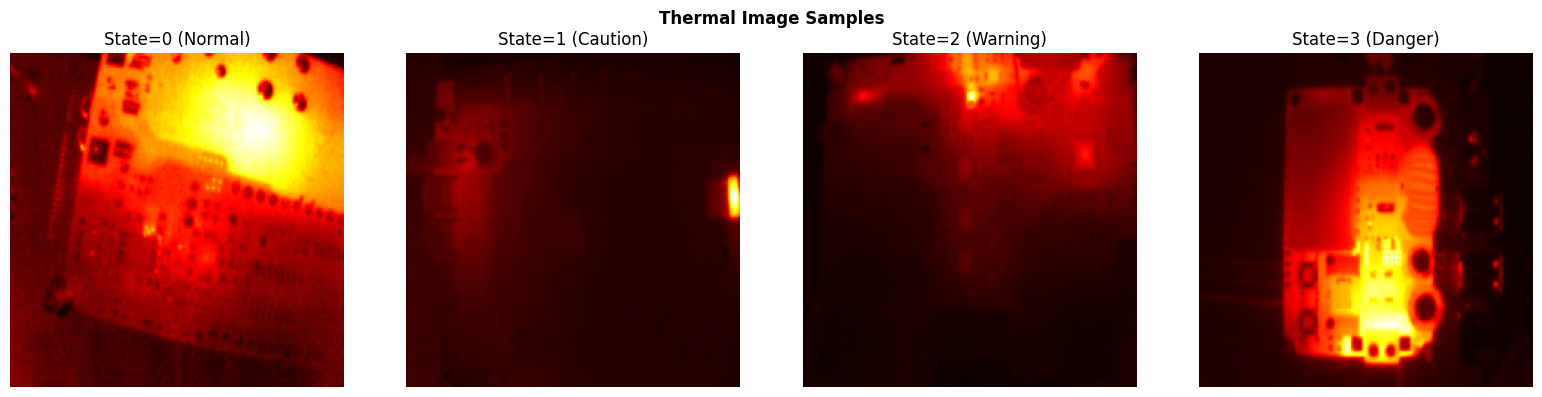

In [ ]:
# ======================================================================
#  BIN 파일 포맷
#
#  구조: [128-byte 헤더] + [120 x 160 float64 픽셀]
#    헤더:  128바이트 (메타데이터, 스킵)
#    픽셀:  120행 x 160열 x 8바이트(float64) = 153,600바이트
#    총합:  128 + 153,600 = 153,728바이트
#
#  각 픽셀 값은 섭씨 온도(℃)를 나타냄 (예: 43.7, 51.2)
#
#  [주의] NaN/Inf 방어
#    실제 BIN 파일 내부에 NaN(Not a Number)과 Inf(무한대)가
#    존재하는 사례가 확인됨 (센서 수집 오류 또는 결측).
#    이를 처리하지 않으면 모델 학습 시 loss가 NaN으로 폭발.
#    -> NaN/Inf를 이미지 중앙값(nanmedian)으로 대체
# ======================================================================

HEADER_SIZE = 128          # BIN 파일 헤더 크기 (바이트)
THERMAL_H, THERMAL_W = 120, 160   # 원본 이미지 해상도
IMG_SIZE = 224             # 모델 입력 크기 (224x224)

# 포맷 확인
sample_bin = windows[0]['bin_path']
file_size = os.path.getsize(sample_bin)
expected_size = HEADER_SIZE + THERMAL_H * THERMAL_W * 8  # float64 = 8 bytes
print(f"BIN 포맷 확인: {file_size:,} bytes, 예상={expected_size:,}, 일치={file_size == expected_size}")


def load_thermal_image(bin_path):
    """
    BIN 파일을 읽어 [1, 224, 224] 텐서로 변환.

    과정:
      1. 128바이트 헤더 스킵
      2. float64로 읽어 120x160 배열 생성
      3. NaN/Inf 값을 이미지 중앙값으로 대체 (안전 처리)
      4. Min-Max 정규화 -> [0, 1] 범위
      5. PIL로 224x224 리사이즈
      6. [1, 224, 224] 텐서 반환

    Args:
        bin_path: BIN 파일 경로

    Returns:
        tensor: [1, 224, 224] float32 텐서 (0~1 범위)
                실패 시 전체 0 텐서 반환
    """
    try:
        raw = np.fromfile(bin_path, dtype=np.uint8)
        data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
        img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)

        # NaN/Inf 방어: 유한하지 않은 값을 중앙값으로 대체
        if not np.all(np.isfinite(img)):
            median_val = np.nanmedian(img)
            if np.isnan(median_val):
                median_val = 0.0
            img = np.where(np.isfinite(img), img, median_val)

        # Min-Max 정규화
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img = (img - vmin) / (vmax - vmin)
        else:
            img = np.zeros_like(img)

        # 224x224 리사이즈
        pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
        pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
        tensor = torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0)
        return tensor.unsqueeze(0)    # [1, 224, 224]
    except:
        return torch.zeros(1, IMG_SIZE, IMG_SIZE)


# ======================================================================
#  NaN/Inf 오염 통계 확인
#  데이터 중 몇 %의 이미지에 NaN/Inf가 포함되어 있는지 확인
# ======================================================================

nan_count = 0
check_n = min(2000, len(windows))
for i in range(check_n):
    try:
        raw = np.fromfile(windows[i]['bin_path'], dtype=np.uint8)
        data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
        img = data.reshape(THERMAL_H, THERMAL_W)
        if not np.all(np.isfinite(img)):
            nan_count += 1
    except:
        pass
print(f"\nNaN/Inf 포함 이미지: {nan_count}/{check_n} ({nan_count/check_n*100:.1f}%)")

# 로딩 테스트
test_img = load_thermal_image(windows[0]['bin_path'])
print(f"로딩 테스트: shape={test_img.shape}, "
      f"범위=[{test_img.min():.3f}, {test_img.max():.3f}], "
      f"NaN={torch.isnan(test_img).any().item()}")

# 시각화: 4개 샘플 열화상 이미지
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, idx in enumerate([0, len(windows)//3, len(windows)*2//3, len(windows)-1]):
    img = load_thermal_image(windows[idx]['bin_path'])
    axes[i].imshow(img.squeeze(), cmap='hot')
    axes[i].set_title(f"State={windows[idx]['label_cls']} ({STATE_MAP[windows[idx]['label_cls']]})")
    axes[i].axis('off')
plt.suptitle('Thermal Image Samples', fontweight='bold')
plt.tight_layout()
plt.show()

# 5-1 번외 ML 성능과 성능개선한 MMT-S모델 비교를 위해 남겨둔 셀 (실행만) (베이스라인)

In [ ]:
# ======================================================================
#  이 셀에서 하는 일:
#    1. ML 모델용 피처 추출 (flatten + 통계량)
#    2. DL 모델용 PyTorch Dataset 정의
#    3. Train / Val / Test DataLoader 생성
# ======================================================================

CACHE_ML_TRAIN = os.path.join(CACHE_DIR, 'ml_train_v2.npz')
CACHE_ML_VAL   = os.path.join(CACHE_DIR, 'ml_val_v2.npz')
CACHE_ML_TEST  = os.path.join(CACHE_DIR, 'ml_test_v2.npz')

# ======================================================================
#  Part 1. ML 피처 추출
#
#  각 윈도우에서 추출하는 피처 (총 277차원):
#    센서 flatten:   30 timesteps x 8 channels = 240
#    센서 통계:      채널별 mean/std/min/max = 8 x 4 = 32
#    열화상 통계:    mean/std/min/max/median = 5
#    합계:           240 + 32 + 5 = 277
# ======================================================================

if (os.path.exists(CACHE_ML_TRAIN) and
    os.path.exists(CACHE_ML_VAL) and
    os.path.exists(CACHE_ML_TEST)):
    d_tr = np.load(CACHE_ML_TRAIN)
    d_va = np.load(CACHE_ML_VAL)
    d_te = np.load(CACHE_ML_TEST)
    X_train_ml, y_train_ml = d_tr['X'], d_tr['y']
    X_val_ml,   y_val_ml   = d_va['X'], d_va['y']
    X_test_ml,  y_test_ml  = d_te['X'], d_te['y']
    print(f"✅ ML 피처 캐시 로드:")
    print(f"   Train={X_train_ml.shape}, Val={X_val_ml.shape}, Test={X_test_ml.shape}")
else:
    def extract_ml_features(windows):
        """
        윈도우 리스트에서 ML용 피처 행렬과 라벨 배열을 추출.

        NaN/Inf 방어 로직 포함:
          열화상 이미지에 NaN/Inf가 있을 경우 중앙값으로 대체 후 통계 계산.

        Returns:
            features: [N, 277] float32 배열
            labels:   [N]     int 배열 (0~3)
        """
        features_list, labels_list = [], []
        for w in tqdm(windows, desc='ML 피처 추출'):
            # (a) 센서 flatten: [30, 8] -> [240]
            sensor_flat = w['sensor'].flatten()

            # (b) 센서 통계: 채널별 mean/std/min/max -> [32]
            sensor = w['sensor']
            s_mean = sensor.mean(axis=0)
            s_std  = sensor.std(axis=0)
            s_min  = sensor.min(axis=0)
            s_max  = sensor.max(axis=0)
            sensor_stats = np.concatenate([s_mean, s_std, s_min, s_max])

            # (c) 열화상 통계: [5]
            try:
                raw = np.fromfile(w['bin_path'], dtype=np.uint8)
                data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
                img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)
                # NaN/Inf 방어
                if not np.all(np.isfinite(img)):
                    med = np.nanmedian(img)
                    if np.isnan(med): med = 0.0
                    img = np.where(np.isfinite(img), img, med)
                img_stats = np.array([
                    img.mean(), img.std(), img.min(), img.max(), np.median(img)
                ])
            except:
                img_stats = np.zeros(5)

            feat = np.concatenate([sensor_flat, sensor_stats, img_stats])
            features_list.append(feat)
            labels_list.append(w['label_cls'])
        return np.array(features_list, dtype=np.float32), np.array(labels_list)

    print("Train 피처 추출 중...")
    X_train_ml, y_train_ml = extract_ml_features(train_windows)
    print("Val 피처 추출 중...")
    X_val_ml, y_val_ml = extract_ml_features(val_windows)
    print("Test 피처 추출 중...")
    X_test_ml, y_test_ml = extract_ml_features(test_windows)

    np.savez(CACHE_ML_TRAIN, X=X_train_ml, y=y_train_ml)
    np.savez(CACHE_ML_VAL,   X=X_val_ml,   y=y_val_ml)
    np.savez(CACHE_ML_TEST,  X=X_test_ml,  y=y_test_ml)
    print(f"✅ ML 피처 캐시 저장 완료")

# StandardScaler: Train 데이터로 fit, Val/Test에 transform
ml_scaler = StandardScaler()
X_train_ml_sc = ml_scaler.fit_transform(X_train_ml)
X_val_ml_sc   = ml_scaler.transform(X_val_ml)
X_test_ml_sc  = ml_scaler.transform(X_test_ml)

print(f"   피처: 센서 flatten({WINDOW_SIZE}x8={WINDOW_SIZE*8}) "
      f"+ 센서 통계(8x4=32) + 열화상 통계(5) = {X_train_ml.shape[1]}")

# ======================================================================
#  Part 2. DL Dataset 정의
#
#  각 샘플 반환값:
#    sensor:    [30, 8]        센서 시계열 (Z-score 정규화)
#    image:     [1, 224, 224]  열화상 이미지 (Min-Max 정규화)
#    label_reg: scalar (float) 회귀 라벨 (0.0 ~ 3.0)
#    label_cls: scalar (int)   분류 라벨 (0, 1, 2, 3)
# ======================================================================

class OHTMultimodalDataset(Dataset):
    """
    OHT 멀티모달 Dataset: 센서 시계열 + 열화상 이미지.

    특징:
      - 센서 정규화: Train의 mean/std로 Z-score 정규화 (Val/Test에도 동일 적용)
      - 이미지 로딩: load_thermal_image() 함수로 NaN/Inf 방어 + Min-Max 정규화
      - 센서 NaN 방어: torch.nan_to_num으로 최종 안전 처리

    Args:
        windows:      윈도우 리스트 (Cell 4에서 생성)
        sensor_mean:  센서 평균 (None이면 자동 계산)
        sensor_std:   센서 표준편차 (None이면 자동 계산)
        fit_scaler:   True이면 이 데이터에서 mean/std 계산 (Train용)
    """
    def __init__(self, windows, sensor_mean=None, sensor_std=None, fit_scaler=False):
        self.windows = windows
        all_sensors = np.stack([w['sensor'] for w in windows])
        if fit_scaler:
            # Train 데이터에서 센서 통계 계산
            self.sensor_mean = all_sensors.reshape(-1, 8).mean(axis=0)
            self.sensor_std  = all_sensors.reshape(-1, 8).std(axis=0) + 1e-8
        else:
            # Val/Test는 Train의 통계 사용
            self.sensor_mean = sensor_mean
            self.sensor_std  = sensor_std

    def __len__(self):
        return len(self.windows)

    def _load_image(self, bin_path):
        """BIN -> [1, 224, 224] 텐서 (NaN/Inf 방어 포함)"""
        try:
            raw = np.fromfile(bin_path, dtype=np.uint8)
            data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
            img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)
            if not np.all(np.isfinite(img)):
                med = np.nanmedian(img)
                if np.isnan(med): med = 0.0
                img = np.where(np.isfinite(img), img, med)
            vmin, vmax = img.min(), img.max()
            if vmax > vmin:
                img = (img - vmin) / (vmax - vmin)
            else:
                img = np.zeros_like(img)
            pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
            pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            tensor = torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0)
            return tensor.unsqueeze(0)
        except:
            return torch.zeros(1, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        w = self.windows[idx]

        # 센서 Z-score 정규화 + NaN 안전 처리
        sensor = (w['sensor'] - self.sensor_mean) / self.sensor_std
        sensor = torch.from_numpy(sensor.astype(np.float32))
        sensor = torch.nan_to_num(sensor, nan=0.0, posinf=3.0, neginf=-3.0)

        # 이미지 로드 (NaN 방어 내장)
        image = self._load_image(w['bin_path'])

        # 라벨
        label_reg = torch.tensor(w['label'], dtype=torch.float32)
        label_cls = torch.tensor(w['label_cls'], dtype=torch.long)

        return sensor, image, label_reg, label_cls

# ======================================================================
#  Part 3. DataLoader 생성
# ======================================================================

# Train: scaler fit (이 데이터에서 센서 mean/std 계산)
train_dataset = OHTMultimodalDataset(train_windows, fit_scaler=True)

# Val/Test: Train의 통계 사용
val_dataset = OHTMultimodalDataset(
    val_windows,
    sensor_mean=train_dataset.sensor_mean,
    sensor_std=train_dataset.sensor_std,
)
test_dataset = OHTMultimodalDataset(
    test_windows,
    sensor_mean=train_dataset.sensor_mean,
    sensor_std=train_dataset.sensor_std,
)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)

# 배치 확인 + NaN 검증
sensor_batch, image_batch, label_reg, label_cls = next(iter(train_loader))
print(f"\n[DL 배치 확인] Sensor: {sensor_batch.shape}, Image: {image_batch.shape}")
print(f"  Sensor NaN: {torch.isnan(sensor_batch).any().item()}")
print(f"  Image  NaN: {torch.isnan(image_batch).any().item()}")
print(f"  Label  NaN: {torch.isnan(label_reg).any().item()}")

print(f"\n✅ 전체 데이터 준비 완료 (NaN/Inf 방어 적용)")
print(f"   Train: {len(train_dataset):>6,} -> {len(train_loader):>4} batches (장비 01~14)")
print(f"   Val:   {len(val_dataset):>6,} -> {len(val_loader):>4} batches (장비 15~16)")
print(f"   Test:  {len(test_dataset):>6,} -> {len(test_loader):>4} batches (장비 17~18)")

Train 피처 추출 중...


ML 피처 추출:   0%|          | 0/79397 [00:00<?, ?it/s]

Val 피처 추출 중...


ML 피처 추출:   0%|          | 0/11292 [00:00<?, ?it/s]

Test 피처 추출 중...


ML 피처 추출:   0%|          | 0/11263 [00:00<?, ?it/s]

✅ ML 피처 캐시 저장 완료
   피처: 센서 flatten(30x8=240) + 센서 통계(8x4=32) + 열화상 통계(5) = 277

[DL 배치 확인] Sensor: torch.Size([32, 30, 8]), Image: torch.Size([32, 1, 224, 224])
  Sensor NaN: False
  Image  NaN: False
  Label  NaN: False

✅ 전체 데이터 준비 완료 (NaN/Inf 방어 적용)
   Train: 79,397 -> 2481 batches (장비 01~14)
   Val:   11,292 ->  353 batches (장비 15~16)
   Test:  11,263 ->  352 batches (장비 17~18)


# 6. DL Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

# =====================================ㅈㅂ=================================
# 🚀 MMT-S 전용 Dataset 정의 (OHT+AGV 통합 & Multi-task 대응)
# ======================================================================

class MMTSTrainingDataset(Dataset):
    """
    MMT-S 모델용 통합 데이터셋.
    1. 센서 시계열 (Z-score 정규화)
    2. 열화상 이미지 (Min-Max 정규화 + NaN 방어)
    3. Multi-task Labels (회귀용/분류용)
    4. [추가] 장비 타입 임베딩 (OHT/AGV 구분용)
    """
    def __init__(self, windows, sensor_mean=None, sensor_std=None, fit_scaler=False):
        self.windows = windows

        # 1. 센서 정규화 파라미터 관리
        if fit_scaler:
            all_sensors = np.stack([w['sensor'] for w in windows])
            # (N, 30, 8) -> (N*30, 8)로 변환하여 채널별 통계 계산
            self.sensor_mean = all_sensors.reshape(-1, 8).mean(axis=0)
            self.sensor_std  = all_sensors.reshape(-1, 8).std(axis=0) + 1e-8
        else:
            self.sensor_mean = sensor_mean
            self.sensor_std  = sensor_std

    def __len__(self):
        return len(self.windows)

    def _load_thermal(self, bin_path):
        """기존 load_thermal_image 로직을 Dataset 내부에 최적화하여 포함"""
        try:
            raw = np.fromfile(bin_path, dtype=np.uint8)
            data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
            img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)

            # NaN/Inf 방어
            if not np.all(np.isfinite(img)):
                med = np.nanmedian(img)
                if np.isnan(med): med = 0.0
                img = np.where(np.isfinite(img), img, med)

            # 정규화
            vmin, vmax = img.min(), img.max()
            img = (img - vmin) / (vmax - vmin) if vmax > vmin else np.zeros_like(img)

            # 리사이즈 (224, 224)
            pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
            pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            tensor = torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0)
            return tensor.unsqueeze(0) # [1, 224, 224]
        except:
            return torch.zeros(1, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        w = self.windows[idx]

        # (a) 센서 데이터 정규화
        sensor = (w['sensor'] - self.sensor_mean) / self.sensor_std
        sensor = torch.from_numpy(sensor.astype(np.float32))
        sensor = torch.nan_to_num(sensor, nan=0.0) # 혹시 모를 결측치 처리

        # (b) 열화상 이미지 로드
        image = self._load_thermal(w['bin_path'])

        # (c) Multi-task 라벨
        label_reg = torch.tensor(w['label'], dtype=torch.float32)
        label_cls = torch.tensor(w['label_cls'], dtype=torch.long)

        # (d) 장비 타입 (OHT: 0, AGV: 1) -> MMT-S가 두 장비의 특성을 구분하도록 도움
        device_type = 0 if w['device_type'] == 'oht' else 1
        device_type = torch.tensor(device_type, dtype=torch.long)

        return {
            'sensor': sensor,
            'image': image,
            'label_reg': label_reg,
            'label_cls': label_cls,
            'device_type': device_type
        }

# ======================================================================
# 🚀 DataLoader 생성 및 가중치 확인
# ======================================================================

BATCH_SIZE = 32

# Dataset 인스턴스화
train_dataset = MMTSTrainingDataset(train_windows, fit_scaler=True)
val_dataset   = MMTSTrainingDataset(val_windows, sensor_mean=train_dataset.sensor_mean, sensor_std=train_dataset.sensor_std)
test_dataset  = MMTSTrainingDataset(test_windows, sensor_mean=train_dataset.sensor_mean, sensor_std=train_dataset.sensor_std)

# DataLoader (MMT-S 전용)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# 샘플 출력 확인
sample = next(iter(train_loader))
print(f"✅ MMT-S Ready: Sensor {sample['sensor'].shape}, Image {sample['image'].shape}")
print(f"📊 Labels: Reg {sample['label_reg'].shape}, Cls {sample['label_cls'].shape}")
# ======================================================================
# 🔎 데이터 준비 상태 상세 점검 (상세 리포트)
# ======================================================================

def print_dataset_report(name, dataset, loader):
    # 클래스 분포 계산
    labels = [w['label_cls'] for w in dataset.windows]
    counts = np.bincount(labels, minlength=4)

    # 장비 타입 분포
    types = [w['device_type'] for w in dataset.windows]
    oht_c = types.count('oht')
    agv_c = types.count('agv')

    print(f"\n📂 [{name} Dataset Report]")
    print(f"  - 총 샘플 수: {len(dataset):>6,} | 배치 수: {len(loader):>4}")
    print(f"  - 장비 분포: OHT({oht_c:,}), AGV({agv_c:,})")
    print(f"  - 클래스 분포:")
    for i, label_name in {0:'Normal', 1:'Caution', 2:'Warning', 3:'Danger'}.items():
        print(f"     └ {label_name:8s}: {counts[i]:>6,} ({counts[i]/len(dataset)*100:4.1f}%)")

# 리포트 실행
print_dataset_report("Train", train_dataset, train_loader)
print_dataset_report("Val", val_dataset, val_loader)
print_dataset_report("Test", test_dataset, test_loader)

# 배치 데이터 최종 무결성 검사
sample = next(iter(train_loader))
print("\n" + "="*50)
print(f"✅ MMT-S 최종 배치 확인")
print(f"  - Sensor: {sample['sensor'].shape} | Image: {sample['image'].shape}")
print(f"  - Labels: Reg {sample['label_reg'].shape} | Cls {sample['label_cls'].shape}")
print(f"  - 결측치(NaN) 검사: Sensor({torch.isnan(sample['sensor']).any().item()}), "
      f"Image({torch.isnan(sample['image']).any().item()})")
print("="*50)

✅ MMT-S Ready: Sensor torch.Size([32, 30, 8]), Image torch.Size([32, 1, 224, 224])
📊 Labels: Reg torch.Size([32]), Cls torch.Size([32])

📂 [Train Dataset Report]
  - 총 샘플 수: 79,397 | 배치 수: 2481
  - 장비 분포: OHT(46,864), AGV(32,533)
  - 클래스 분포:
     └ Normal  : 35,611 (44.9%)
     └ Caution : 18,488 (23.3%)
     └ Warning : 18,608 (23.4%)
     └ Danger  :  6,690 ( 8.4%)

📂 [Val Dataset Report]
  - 총 샘플 수: 11,292 | 배치 수:  353
  - 장비 분포: OHT(6,646), AGV(4,646)
  - 클래스 분포:
     └ Normal  :  4,887 (43.3%)
     └ Caution :  2,701 (23.9%)
     └ Warning :  2,714 (24.0%)
     └ Danger  :    990 ( 8.8%)

📂 [Test Dataset Report]
  - 총 샘플 수: 11,263 | 배치 수:  352
  - 장비 분포: OHT(6,646), AGV(4,617)
  - 클래스 분포:
     └ Normal  :  4,512 (40.1%)
     └ Caution :  2,892 (25.7%)
     └ Warning :  2,869 (25.5%)
     └ Danger  :    990 ( 8.8%)

✅ MMT-S 최종 배치 확인
  - Sensor: torch.Size([32, 30, 8]) | Image: torch.Size([32, 1, 224, 224])
  - Labels: Reg torch.Size([32]) | Cls torch.Size([32])
  - 결측치(NaN) 검사: Sen

# 7. ML 모델 학습 & 평가 (베이스라인)

In [ ]:
# ======================================================================
#  4가지 ML 모델 학습 및 평가
#
#  모델 구성:
#    RandomForest:  앙상블 결정 트리 (CPU)
#    XGBoost:       Gradient Boosting (GPU 가속, device='cuda')
#    LightGBM:      경량 Gradient Boosting (GPU 가속)
#    CatBoost:      범주형 지원 Gradient Boosting (GPU 가속)
#
#  입력: 277차원 피처 벡터 (센서 flatten + 통계 + 열화상 통계)
#  출력: 4클래스 분류 (0=정상, 1=관심, 2=경고, 3=위험)
#
#  평가: Train(장비 01~14) + Val(장비 15~16) + Test(장비 17~18) 모두 출력
#
#  [참고] 트리 기반 모델은 스케일링 불필요
#    RF/XGB/LGBM/CatBoost는 분할 기준이 순서(rank)이므로
#    StandardScaler 적용 여부가 결과에 영향 없음.
#    따라서 fit과 predict 모두 원본(unscaled) 데이터 사용.
#    (X_train_ml_sc는 DL 피처용으로 별도 존재)
#
#  [XGBoost 3.1+ 변경사항]
#    tree_method='gpu_hist'와 gpu_id 파라미터가 제거됨.
#    대신 device='cuda' (GPU) 또는 device='cpu' (CPU)를 사용.
# ======================================================================

def evaluate_predictions(y_true, y_pred_cls, y_pred_reg=None):
    """
    분류 예측 결과로 RMSE, Macro F1, Macro Recall 계산.

    Args:
        y_true:      실제 라벨 (int, 0~3)
        y_pred_cls:  예측 클래스 (int, 0~3)
        y_pred_reg:  회귀 예측값 (float, 없으면 cls 사용)

    Returns:
        rmse, f1, recall
    """
    if y_pred_reg is None:
        y_pred_reg = y_pred_cls.astype(float)
    rmse   = np.sqrt(mean_squared_error(y_true.astype(float), y_pred_reg))
    f1     = f1_score(y_true, y_pred_cls, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred_cls, average='macro', zero_division=0)
    return rmse, f1, recall


# 모델 정의 (GPU 가속 옵션 포함)
ml_models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=300, max_depth=20, min_samples_split=5,
        class_weight='balanced', random_state=42, n_jobs=-1),

    'XGBoost': XGBClassifier(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        device='cuda',
        random_state=42, eval_metric='mlogloss', use_label_encoder=False),

    'LightGBM': LGBMClassifier(
        n_estimators=300, max_depth=10, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        class_weight='balanced', random_state=42,
        device='gpu', gpu_use_dp=False, verbose=-1),

    'CatBoost': CatBoostClassifier(
        iterations=300, depth=8, learning_rate=0.1,
        task_type='GPU', devices='0',
        auto_class_weights='Balanced', random_seed=42, verbose=0),
}

# 전체 실험 결과를 누적할 리스트
all_results = []

CACHE_ML_RESULTS = os.path.join(CACHE_DIR, 'ml_results_v3.pkl')

# ======================================================================
#  캐시 존재 시 로드
# ======================================================================

if os.path.exists(CACHE_ML_RESULTS):
    with open(CACHE_ML_RESULTS, 'rb') as f:
        cache = pickle.load(f)
        all_results = cache['all_results']
        ml_models   = cache['ml_models']
    print(f"✅ ML 결과 캐시 로드: {len(all_results)}개 모델")
    for r in all_results:
        print(f"  {r['Model']:15s}: Train F1={r['Train F1']:.4f}, "
              f"Val F1={r['Val F1']:.4f}, Test F1={r['Test F1']:.4f}")

else:
    print(f"{'='*65}")
    print(f"  ML Models Training ({len(ml_models)} models)")
    print(f"{'='*65}")

    for name, model in ml_models.items():
        print(f"\n  > Training: {name}...", end=' ')
        t0 = time.time()
        try:
            model.fit(X_train_ml, y_train_ml)
            elapsed = time.time() - t0

            # Train / Val / Test 모두 평가 (unscaled 원본 사용)
            y_train_pred = model.predict(X_train_ml)
            y_val_pred   = model.predict(X_val_ml)
            y_test_pred  = model.predict(X_test_ml)

            train_rmse, train_f1, train_recall = evaluate_predictions(y_train_ml, y_train_pred)
            val_rmse,   val_f1,   val_recall   = evaluate_predictions(y_val_ml, y_val_pred)
            test_rmse,  test_f1,  test_recall  = evaluate_predictions(y_test_ml, y_test_pred)

            all_results.append({
                'Category': 'ML', 'Model': name,
                'Train RMSE': train_rmse, 'Train F1': train_f1, 'Train Recall': train_recall,
                'Val RMSE': val_rmse, 'Val F1': val_f1, 'Val Recall': val_recall,
                'Test RMSE': test_rmse, 'Test F1': test_f1, 'Test Recall': test_recall,
                'Time(s)': elapsed,
            })
            print(f"완료 ({elapsed:.1f}s)")
            print(f"    Train: RMSE={train_rmse:.4f}, F1={train_f1:.4f}, Recall={train_recall:.4f}")
            print(f"    Val:   RMSE={val_rmse:.4f}, F1={val_f1:.4f}, Recall={val_recall:.4f}")
            print(f"    Test:  RMSE={test_rmse:.4f}, F1={test_f1:.4f}, Recall={test_recall:.4f}")

        except Exception as e:
            print(f"GPU 실패 -> CPU 재시도: {e}")
            if name == 'XGBoost':
                model = XGBClassifier(
                    n_estimators=300, max_depth=8, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.8,
                    device='cpu',
                    random_state=42, eval_metric='mlogloss', use_label_encoder=False)
            elif name == 'LightGBM':
                model = LGBMClassifier(
                    n_estimators=300, max_depth=10, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.8, class_weight='balanced',
                    random_state=42, device='cpu', verbose=-1)
            elif name == 'CatBoost':
                model = CatBoostClassifier(
                    iterations=300, depth=8, learning_rate=0.1,
                    task_type='CPU', auto_class_weights='Balanced',
                    random_seed=42, verbose=0)

            ml_models[name] = model
            t0 = time.time()
            model.fit(X_train_ml, y_train_ml)
            elapsed = time.time() - t0

            # CPU fallback도 unscaled 원본 사용
            y_train_pred = model.predict(X_train_ml)
            y_val_pred   = model.predict(X_val_ml)
            y_test_pred  = model.predict(X_test_ml)

            train_rmse, train_f1, train_recall = evaluate_predictions(y_train_ml, y_train_pred)
            val_rmse,   val_f1,   val_recall   = evaluate_predictions(y_val_ml, y_val_pred)
            test_rmse,  test_f1,  test_recall  = evaluate_predictions(y_test_ml, y_test_pred)

            all_results.append({
                'Category': 'ML', 'Model': name,
                'Train RMSE': train_rmse, 'Train F1': train_f1, 'Train Recall': train_recall,
                'Val RMSE': val_rmse, 'Val F1': val_f1, 'Val Recall': val_recall,
                'Test RMSE': test_rmse, 'Test F1': test_f1, 'Test Recall': test_recall,
                'Time(s)': elapsed,
            })
            print(f"    완료 ({elapsed:.1f}s)")
            print(f"    Train: RMSE={train_rmse:.4f}, F1={train_f1:.4f}, Recall={train_recall:.4f}")
            print(f"    Val:   RMSE={val_rmse:.4f}, F1={val_f1:.4f}, Recall={val_recall:.4f}")
            print(f"    Test:  RMSE={test_rmse:.4f}, F1={test_f1:.4f}, Recall={test_recall:.4f}")

    with open(CACHE_ML_RESULTS, 'wb') as f:
        pickle.dump({'all_results': all_results, 'ml_models': ml_models}, f)
    print(f"\n✅ ML 결과 캐시 저장 완료")

# ======================================================================
#  결과 요약 테이블
# ======================================================================

print(f"\n{'='*95}")
print(f"  ML 모델 Train / Val / Test 성능 비교")
print(f"{'='*95}")
print(f"  {'모델':15s} | {'Train RMSE':>10s} {'Train F1':>9s} | "
      f"{'Val RMSE':>9s} {'Val F1':>7s} | {'Test RMSE':>10s} {'Test F1':>8s}")
print(f"  {'─'*90}")
for r in all_results:
    if r['Category'] != 'ML':
        continue
    print(f"  {r['Model']:15s} | "
          f"{r['Train RMSE']:>10.4f} {r['Train F1']:>9.4f} | "
          f"{r['Val RMSE']:>9.4f} {r['Val F1']:>7.4f} | "
          f"{r['Test RMSE']:>10.4f} {r['Test F1']:>8.4f}")
print(f"{'='*95}")

  ML Models Training (4 models)

  > Training: RandomForest... 완료 (26.9s)
    Train: RMSE=0.0094, F1=0.9999, Recall=0.9999
    Val:   RMSE=0.2087, F1=0.9536, Recall=0.9543
    Test:  RMSE=0.3148, F1=0.9467, Recall=0.9522

  > Training: XGBoost... 완료 (4.7s)
    Train: RMSE=0.0000, F1=1.0000, Recall=1.0000
    Val:   RMSE=0.1783, F1=0.9666, Recall=0.9675
    Test:  RMSE=0.3037, F1=0.9534, Recall=0.9567

  > Training: LightGBM... 완료 (14.8s)
    Train: RMSE=0.0000, F1=1.0000, Recall=1.0000
    Val:   RMSE=0.1863, F1=0.9640, Recall=0.9650
    Test:  RMSE=0.3118, F1=0.9495, Recall=0.9546

  > Training: CatBoost... 완료 (3.8s)
    Train: RMSE=0.0842, F1=0.9908, Recall=0.9929
    Val:   RMSE=0.1793, F1=0.9637, Recall=0.9649
    Test:  RMSE=0.2980, F1=0.9557, Recall=0.9608

✅ ML 결과 캐시 저장 완료

  ML 모델 Train / Val / Test 성능 비교
  모델              | Train RMSE  Train F1 |  Val RMSE  Val F1 |  Test RMSE  Test F1
  ──────────────────────────────────────────────────────────────────────────────────────────

# 8. DL 모델 정의

In [ ]:
# ==============================================================================
#  1. CNN (RegNetY-3.2GF) — 단일모달: 열화상 이미지만 사용
# ==============================================================================
#
#  [논문 대응]
#    논문 표4 첫 두 행: "CNN (RegNet3.2)" — 열화상 이미지 단독 입력
#    논문 결과: CNN(1ch) RMSE=0.3743 F1=0.7792
#              CNN(3ch) RMSE=0.3514 F1=0.7956
#
#  [아키텍처 상세]
#    RegNetY-3.2GF (Radosavovic et al., 2020)
#    +-- Stem   : Conv2d(in_ch -> 32) -> BN -> ReLU
#    +-- Stage 1: YBlock x n  (32   -> 72,   stride=2)
#    +-- Stage 2: YBlock x n  (72   -> 216,  stride=2)
#    +-- Stage 3: YBlock x n  (216  -> 576,  stride=2)
#    +-- Stage 4: YBlock x n  (576  -> 1512, stride=2)
#    +-- Global Average Pooling -> [B, 1512]
#    +-- FC Head: 1512 -> 256 -> 1 (회귀 출력)
#
#    * YBlock: 1x1 Conv -> Group Conv (with SE) -> 1x1 Conv + Skip
#    * SE (Squeeze-and-Excitation): 채널별 중요도 학습
#    * 총 파라미터: ~18.3M (ImageNet 분류 모델 대비 경량)
#
#  [1ch vs 3ch 차이]
#    - 1채널: 현재 시점의 열화상 1장 그대로 입력 [B, 1, 224, 224]
#    - 3채널: 논문에서는 연속 3시점의 열화상을 채널축으로 쌓음
#             -> 시간적 변화 패턴 캡처 (온도 상승/하강 추세)
#             현재 구현: 데이터 구조상 동일 이미지 3ch 복제로 대체
#             -> 첫 Conv 가중치가 3배이므로 약간의 용량 차이만 존재
#
#  [논문에서 이 모델의 역할]
#    열화상 이미지만으로 열화 상태를 예측하는 베이스라인.
#    센서 정보 없이도 이미지만으로 어느 정도 예측 가능함을 보여주되,
#    LSTM(센서)이나 MMT(멀티모달)보다 성능이 낮음을 대조하기 위한 모델.
# ==============================================================================

class CNNRegNet(nn.Module):
    """
    RegNetY-3.2GF 기반 단일모달 CNN 회귀 모델.

    입력:  열화상 이미지 [B, 1, 224, 224]  (센서 데이터는 무시)
    출력:  열화 상태 연속값 [B]  (0.0 ~ 3.0 범위 학습)

    Args:
        in_channels (int): 입력 채널 수
            - 1: grayscale 열화상 1장
            - 3: 동일 이미지 3ch 복제 (또는 연속 3시점)
    """
    def __init__(self, in_channels=1):
        super().__init__()
        self.in_channels = in_channels

        # RegNetY-3.2GF 로드 (scratch 학습, pretrained 미사용)
        # 논문에서도 ImageNet pretrained 사용 여부 미언급
        # -> 도메인(열화상)이 자연 이미지와 매우 다르므로 scratch가 적절
        regnet = tv_models.regnet_y_3_2gf(weights=None)

        # 첫번째 Conv를 in_channels에 맞게 교체
        # 원래 3ch(RGB) -> in_channels로 변경
        orig_conv = regnet.stem[0]
        regnet.stem[0] = nn.Conv2d(
            in_channels, orig_conv.out_channels,       # 32 출력 채널 유지
            kernel_size=orig_conv.kernel_size,          # (3, 3)
            stride=orig_conv.stride,                    # (2, 2)
            padding=orig_conv.padding,                  # (1, 1)
            bias=(orig_conv.bias is not None)           # False (BN이 뒤따르므로)
        )

        # backbone = Stem + 4개 Stage (feature extractor)
        self.backbone = nn.Sequential(
            regnet.stem,            # Conv -> BN -> ReLU, 224->112
            regnet.trunk_output,    # Stage1~4, 112->7
        )

        # Global Average Pooling: [B, 1512, 7, 7] -> [B, 1512]
        self.pool = nn.AdaptiveAvgPool2d(1)

        # 출력 차원 동적 감지 (RegNet 버전 변경에도 안전)
        with torch.no_grad():
            feat_dim = self.backbone(torch.zeros(1, in_channels, 224, 224)).shape[1]

        # 회귀 Head: 2층 FC
        # 1512 -> 256 (차원 축소) -> 1 (스칼라 회귀 출력)
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.GELU(),                  # 부드러운 활성화 (ReLU보다 안정적)
            nn.Dropout(0.1),            # 과적합 방지 (경량 정규화)
            nn.Linear(256, 1),
        )

    def forward(self, sensor, image):
        """
        Args:
            sensor: [B, 30, 8]       -- 사용하지 않음 (단일모달, 통일된 인터페이스)
            image:  [B, 1, 224, 224] -- 열화상 이미지 (min-max 정규화 완료)

        Returns:
            pred: [B] -- 열화 상태 회귀값 (0~3 연속값)
        """
        # 3ch 모델: 1ch 이미지를 채널 방향으로 3번 복제
        if self.in_channels == 3:
            x = image.repeat(1, 3, 1, 1)    # [B,1,H,W] -> [B,3,H,W]
        else:
            x = image                        # [B,1,H,W] 그대로

        x = self.backbone(x)                # [B, 1512, 7, 7]
        x = self.pool(x)                    # [B, 1512, 1, 1]
        x = x.flatten(1)                    # [B, 1512]
        return self.head(x).squeeze(-1)     # [B]


# ==============================================================================
#  2. LSTM — 단일모달: 센서 시계열만 사용
# ==============================================================================
#
#  [논문 대응]
#    논문 표4: "LSTM" — 센서 시계열 (30 타임스텝 x 8 채널)
#    논문 결과: RMSE=0.3307 F1=0.8582
#    -> CNN(이미지 단독)보다 훨씬 좋음 = 센서 데이터의 열화 예측력이 높음
#
#  [아키텍처 상세]
#
#    입력: [B, 30, 8]
#      |
#      |   8 채널 구성:
#      |     PM10, PM2.5, PM1.0 -- 미세먼지 농도 (장비 내부 분진 축적)
#      |     NTC                -- 서미스터 온도 (전체 온도)
#      |     CT1, CT2, CT3, CT4 -- 접촉식 온도 센서 (국소 발열 감지)
#      |
#      v
#    +---------------------------------------------+
#    |  LSTM Layer 1 (Bidirectional)               |
#    |    순방향 --->  hidden_dim=128               |
#    |    역방향 <---  hidden_dim=128               |
#    |    출력: [B, 30, 256]                        |
#    +---------------------------------------------+
#      |  (dropout=0.2)
#      v
#    +---------------------------------------------+
#    |  LSTM Layer 2 (Bidirectional)               |
#    |    순방향 --->  hidden_dim=128               |
#    |    역방향 <---  hidden_dim=128               |
#    |    출력: [B, 30, 256]                        |
#    +---------------------------------------------+
#      |
#      v  마지막 타임스텝 추출: out[:, -1, :] -> [B, 256]
#      |    순방향(1~30 전체 요약) + 역방향(30~1 전체 요약)
#      v
#    +---------------------------------------------+
#    |  FC Head: 256 -> 128 -> 1                   |
#    +---------------------------------------------+
#      |
#      v  pred: [B]
#
#  [논문에서 이 모델의 역할]
#    센서 시계열만으로 열화 예측하는 베이스라인.
#    이미지 없이도 시계열 패턴으로 열화 상태를 잘 잡아냄.
#    -> CNN+LSTM이나 MMT와 비교하여 이미지 추가의 이점을 평가.
# ==============================================================================

class SensorLSTM(nn.Module):
    """
    Bidirectional LSTM 기반 센서 시계열 회귀 모델.

    입력:  센서 시계열 [B, 30, 8]  (이미지 데이터는 무시)
    출력:  열화 상태 연속값 [B]

    Args:
        input_dim  (int): 센서 채널 수 (8: PM10/PM2.5/PM1.0/NTC/CT1~4)
        hidden_dim (int): LSTM hidden state 차원 (128)
                          -> 양방향이므로 실제 출력 = 256
        num_layers (int): LSTM 레이어 수 (2: 충분한 시계열 모델링)
        dropout   (float): 레이어 간 Dropout (0.2)
    """
    def __init__(self, input_dim=8, hidden_dim=128, num_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,       # 8 센서 채널
            hidden_size=hidden_dim,     # 128
            num_layers=num_layers,      # 2층 스택
            batch_first=True,           # 입력: [B, T, F]
            dropout=dropout if num_layers > 1 else 0,  # 레이어 간 dropout
            bidirectional=True,         # 양방향 -> 출력 dim = hidden*2 = 256
        )

        # 회귀 Head: 양방향 출력(256) -> 128 -> 1
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),   # 256 -> 128
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1),                # 128 -> 1
        )

    def forward(self, sensor, image):
        """
        Args:
            sensor: [B, 30, 8]       -- 30 타임스텝 x 8 센서 채널 (정규화 완료)
            image:  [B, 1, 224, 224] -- 사용하지 않음 (통일된 인터페이스)

        Returns:
            pred: [B] -- 열화 상태 회귀값
        """
        # LSTM 전체 시퀀스 출력
        # out: [B, 30, 256]  (각 타임스텝의 양방향 hidden)
        # hn:  [4, B, 128]   (2layers x 2directions)
        out, (hn, cn) = self.lstm(sensor)

        # 마지막 타임스텝(t=30)의 출력 사용
        # -> 순방향: 1~30 전체 요약 / 역방향: 30~1 전체 요약
        last_hidden = out[:, -1, :]     # [B, 256]

        return self.head(last_hidden).squeeze(-1)   # [B]


# ==============================================================================
#  3. CNN + LSTM — 멀티모달: 이미지(CNN) + 센서(LSTM) Late Fusion
# ==============================================================================
#
#  [논문 대응]
#    논문 표4: "CNN + LSTM" — 이미지(CNN) + 센서(LSTM)
#    논문 결과: RMSE=0.3095 F1=0.8660
#    -> LSTM 단독(0.8582)보다 개선 = 이미지가 센서에 보완적 정보 제공
#
#  [아키텍처 상세]
#
#    Image [B, 1, 224, 224]          Sensor [B, 30, 8]
#           |                               |
#           v                               v
#    +----------------+              +----------------+
#    |    RegNet      |              |    BiLSTM      |
#    |  (Stage 1~4)   |              |  (2 layers)    |
#    +----------------+              +----------------+
#           |                               |
#           v                               v
#    +----------------+              +----------------+
#    |      GAP       |              |  last hidden   |
#    |  [B, 1512]     |              |  [B, 256]      |
#    +----------------+              +----------------+
#           |                               |
#           +---------- Concat -------------+
#                         |
#                         v
#                  [B, 1512 + 256 = 1768]
#                         |
#                         v
#               +--------------------+
#               |     FC Head        |
#               |  1768 -> 256 -> 64 |
#               |       -> 1        |
#               +--------------------+
#                         |
#                         v
#                    pred: [B]
#
#  [Late Fusion 전략]
#    각 모달리티를 독립적으로 인코딩 후 마지막에 결합
#    -> 구현이 단순하고 안정적이지만,
#       모달리티 간 세밀한 상호작용은 학습하기 어려움
#    -> 이것이 MMT(Transformer 기반 Early Fusion)와의 핵심 차이
#
#    논문과의 일치를 위해 CNN 브랜치에도 RegNet 사용
#    (이전 버전은 단순 4-layer Conv였으나, 논문은 동일 RegNet 사용)
#
#  [논문에서 이 모델의 역할]
#    멀티모달 융합의 기본적인 접근(Late Fusion)으로,
#    MMT의 Transformer 기반 융합(전역 Self-Attention)과 비교하기 위한 모델.
#    CNN+LSTM < MMT -> Transformer의 크로스모달 어텐션이 우수함을 입증.
# ==============================================================================

class CNN_LSTM(nn.Module):
    """
    멀티모달 CNN+LSTM Late Fusion 회귀 모델.

    이미지 브랜치:  RegNetY-3.2GF -> GAP -> [B, 1512]
    센서 브랜치:    BiLSTM (2층, h=128) -> last hidden -> [B, 256]
    융합:           Concat [B, 1768] -> FC -> [B, 1]

    Args:
        sensor_dim (int): 센서 입력 차원 (8)
        hidden_dim (int): LSTM hidden 차원 (128, 양방향->256)
        num_layers (int): LSTM 레이어 수 (2)
    """
    def __init__(self, sensor_dim=8, hidden_dim=128, num_layers=2):
        super().__init__()

        # CNN 브랜치: RegNet (논문과 동일한 backbone)
        # CNN 단독 모델과 같은 RegNet 사용 -> 공정한 비교
        regnet = tv_models.regnet_y_3_2gf(weights=None)
        orig_conv = regnet.stem[0]
        regnet.stem[0] = nn.Conv2d(
            1, orig_conv.out_channels,                  # 1ch 열화상 입력
            kernel_size=orig_conv.kernel_size,
            stride=orig_conv.stride,
            padding=orig_conv.padding,
            bias=(orig_conv.bias is not None)
        )
        self.cnn_backbone = nn.Sequential(
            regnet.stem,            # 224 -> 112
            regnet.trunk_output,    # 112 -> 7
        )
        self.cnn_pool = nn.AdaptiveAvgPool2d(1)     # [B,1512,7,7] -> [B,1512,1,1]

        # CNN 출력 차원 동적 감지
        with torch.no_grad():
            cnn_out_dim = self.cnn_backbone(torch.zeros(1, 1, 224, 224)).shape[1]

        # LSTM 브랜치: LSTM 단독 모델과 동일 구조
        self.lstm = nn.LSTM(
            input_size=sensor_dim,      # 8
            hidden_size=hidden_dim,     # 128
            num_layers=num_layers,      # 2
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0,
            bidirectional=True,         # -> 출력 256
        )
        lstm_out_dim = hidden_dim * 2   # 256

        # Fusion Head
        # Late Fusion: 두 브랜치의 피처 벡터를 단순 concat
        # [1512 + 256 = 1768] -> 256 -> 64 -> 1
        fusion_dim = cnn_out_dim + lstm_out_dim
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 256),     # 1768 -> 256 (대폭 축소)
            nn.GELU(),
            nn.Dropout(0.2),                # fusion 부분은 과적합 위험 높음
            nn.Linear(256, 64),             # 256  -> 64
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),               # 64   -> 1 (스칼라 회귀)
        )

    def forward(self, sensor, image):
        """
        Args:
            sensor: [B, 30, 8]       -- 센서 시계열 (정규화 완료)
            image:  [B, 1, 224, 224] -- 열화상 이미지 (min-max 정규화 완료)

        Returns:
            pred: [B] -- 열화 상태 회귀값 (0~3 연속값)
        """
        # CNN 브랜치: 이미지 -> 고정 길이 피처 벡터
        img_feat = self.cnn_backbone(image)         # [B, 1512, 7, 7]
        img_feat = self.cnn_pool(img_feat)          # [B, 1512, 1, 1]
        img_feat = img_feat.flatten(1)              # [B, 1512]

        # LSTM 브랜치: 센서 -> 고정 길이 피처 벡터
        lstm_out, _ = self.lstm(sensor)             # [B, 30, 256]
        sen_feat = lstm_out[:, -1, :]               # [B, 256]

        # Late Fusion: Concat -> FC
        fused = torch.cat([img_feat, sen_feat], dim=1)  # [B, 1768]
        return self.head(fused).squeeze(-1)              # [B]


# ==============================================================================
#  4. MMT — MultiModal Transformer (논문의 핵심 제안 모델)
# ==============================================================================
#
#  [논문 대응]
#    논문 표4: "MultiModal Transformer" — 이미지 패치 + 센서 토큰
#    논문 결과: RMSE=0.2875 F1=0.8944 (전체 최고 성능)
#    -> CNN+LSTM(Late Fusion)보다 개선 = Transformer 크로스모달 어텐션 효과
#
#  [핵심 아이디어]
#    CNN+LSTM의 Late Fusion은 각 모달리티를 독립 인코딩 -> 마지막에 결합.
#    -> 모달리티 간 세밀한 관계를 직접 학습할 수 없음.
#       (예: 이미지의 특정 영역 온도 <-> CT 센서값)
#
#    MMT는 이미지 패치와 센서 토큰을 하나의 시퀀스로 만든 뒤
#    Transformer Self-Attention으로 모든 토큰이 서로를 참조하게 함.
#    -> 이미지 패치 <-> 센서 토큰 간 크로스모달 상호작용을 자연스럽게 학습
#
#  [아키텍처 상세 — 논문 Fig.4 기반]
#
#    Image [B, 1, 224, 224]              Sensor [B, 30, 8]
#           |                                   |
#           v                                   v
#    +------------------+                +------------------+
#    | 16x16 Patchify   |                | Linear Embed     |
#    | 196 patches      |                | 8 -> d_model     |
#    | each 256-dim     |                | 30 tokens        |
#    +------------------+                +------------------+
#           |                                   |
#           v                                   v
#    +------------------+                +------------------+
#    | Linear Embed     |                | + Positional     |
#    | 256 -> d_model   |                |   Embedding      |
#    | + Positional     |                |   (temporal)     |
#    |   Embedding      |                +------------------+
#    |   (spatial)      |                       |
#    +------------------+                       |
#           |                                   |
#           +-------+    [CLS]    +-------------+
#                   |    Token    |
#                   v      v      v
#              +----------------------------+
#              |        Concat              |
#              | [CLS] + Image + Sensor     |
#              | 1 + 196 + 30 = 227 tokens  |
#              | each d_model dim           |
#              +----------------------------+
#                          |
#                          v
#              +----------------------------+
#              |   Transformer Encoder      |
#              |   x L layers (Pre-LN)      |
#              |                            |
#              |   +----------------------+ |
#              |   | LN -> MHSA -> + res  | |
#              |   | LN -> FFN  -> + res  | |
#              |   +----------------------+ |
#              |                            |
#              |   Self-Attention 범위:      |
#              |     Img<->Img   (공간)      |
#              |     Sen<->Sen   (시간)      |
#              |     Img<->Sen   (크로스!)    |
#              |     CLS<->All   (집약)      |
#              +----------------------------+
#                          |
#                          v
#              +----------------------------+
#              |   [CLS] output             |
#              |   -> LayerNorm             |
#              |   -> FC: d -> d/2 -> 1     |
#              +----------------------------+
#                          |
#                          v
#                     pred: [B]
#
#  [Positional Embedding 설계]
#    - 이미지 위치 임베딩: 196개 패치의 2D 공간 위치 (학습 가능, ViT 방식)
#    - 센서 위치 임베딩:   30개 타임스텝의 시간 순서 (학습 가능)
#    - 두 임베딩은 별도: 이미지(공간)와 센서(시간)의 위치 개념이 다르므로
#
#  [Pre-LayerNorm vs Post-LayerNorm]
#    Pre-LN(norm_first=True) 사용.
#    Pre-LN이 학습 안정성이 높고 warmup 의존도가 낮음 (Xiong et al., 2020).
#
#  [CNN+LSTM(Late Fusion)과의 핵심 차이]
#    CNN+LSTM: 각 모달리티를 별도 인코더로 처리 -> 마지막에 concat
#              -> 피처 수준의 단순 결합 (상호작용 없음)
#    MMT:      모든 토큰을 단일 시퀀스로 -> Self-Attention으로 전역 상호작용
#              -> 이미지의 어떤 영역이 어떤 센서값과 관련 있는지 직접 학습
#              -> 특히 CT센서(국소 온도) <-> 이미지 핫스팟 영역의 대응 관계
#
#  [논문 미공개 하이퍼파라미터 -> 3가지 규모 실험]
#    논문에서 d_model, num_layers, nhead, d_ff 미공개.
#    합리적 범위에서 3가지 규모로 실험:
#
#    +-------+---------+-------+--------+------+----------+
#    | 변형  | d_model | heads | layers | d_ff | 파라미터 |
#    +-------+---------+-------+--------+------+----------+
#    | MMT-S |   128   |   4   |   4    |  512 |   ~865K  |
#    | MMT-B |   256   |   8   |   4    | 1024 |   ~3.4M  |
#    | MMT-L |   384   |   6   |   6    | 1536 |   ~11M   |
#    +-------+---------+-------+--------+------+----------+
#
#    S: 초경량, 빠른 실험 / B: 중간 / L: CNN+LSTM과 유사한 용량
#    -> 논문 결과(RMSE=0.2875)에 가장 가까운 설정을 실험적으로 탐색
# ==============================================================================

class MultimodalTransformer(nn.Module):
    """
    논문의 MMT (Multimodal Transformer) 구현.

    이미지 패치 토큰(196) + 센서 시계열 토큰(30) + [CLS](1) = 227 토큰을
    단일 Transformer Encoder에서 전역 Self-Attention으로 처리.
    [CLS] 토큰의 최종 출력을 사용하여 열화 상태를 회귀 예측.

    입력:
        sensor: [B, 30, 8]       -- 센서 시계열 (30 timesteps x 8 channels)
        image:  [B, 1, 224, 224] -- 열화상 이미지 (grayscale)

    출력:
        pred: [B] -- 열화 상태 연속값 (0.0 ~ 3.0)

    Args:
        img_size       (int): 이미지 크기 (224)
        patch_size     (int): 패치 크기 (16) -> (224/16)^2 = 196 패치
        in_channels    (int): 이미지 채널 (1, grayscale 열화상)
        sensor_seq_len (int): 센서 시퀀스 길이 (30 타임스텝)
        sensor_dim     (int): 센서 채널 수 (8: PM10/PM2.5/PM1.0/NTC/CT1~4)
        d_model        (int): Transformer 임베딩 차원
        nhead          (int): Multi-Head Attention 헤드 수 (d_model % nhead == 0)
        num_layers     (int): Transformer Encoder 레이어 수
        d_ff           (int): FFN 중간 차원 (보통 d_model x 4)
        dropout       (float): Attention/FFN 내 Dropout 비율
        [추가 기능]
    1. Multi-task Head: 회귀(열화지수)와 분류(4개 클래스) 동시 출력
    2. Device Embedding: OHT/AGV 장비 특성 반영
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=1,
                 sensor_seq_len=30, sensor_dim=8,
                 d_model=128, nhead=4, num_layers=4, d_ff=512, dropout=0.1):
        super().__init__()
        self.d_model    = d_model
        self.patch_size = patch_size

        # 패치 수: (224 / 16)^2 = 14^2 = 196
        num_patches = (img_size // patch_size) ** 2     # 196
        # 패치 flatten 차원: C x P x P = 1 x 16 x 16 = 256
        patch_dim = in_channels * patch_size ** 2       # 256
        self.num_patches = num_patches

        # Image Patch Embedding
        # 각 16x16 패치(256dim)를 d_model 차원으로 선형 투영
        # = ViT의 "Linear Projection of Flattened Patches"
        self.patch_embed = nn.Linear(patch_dim, d_model)

        # 학습 가능한 이미지 위치 임베딩 (196개 패치의 2D 공간 위치)
        # 초기값: N(0, 0.02) — ViT 논문과 동일한 초기화
        self.img_pos_embed = nn.Parameter(
            torch.randn(1, num_patches, d_model) * 0.02
        )

        # Sensor Embedding
        # 각 타임스텝의 8차원 센서값을 d_model 차원으로 투영
        self.sensor_embed = nn.Linear(sensor_dim, d_model)

        # 학습 가능한 센서 위치 임베딩 (30개 타임스텝의 시간 순서)
        self.sensor_pos_embed = nn.Parameter(
            torch.randn(1, sensor_seq_len, d_model) * 0.02
        )

        # [CLS] Token
        # BERT/ViT 스타일: 전체 시퀀스를 대표하는 학습 가능한 토큰
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, d_model) * 0.02
        )
        # 장비 종류가 2종(OHT, AGV)이므로 2개 임베딩 생성
        self.device_embed = nn.Embedding(2, d_model)

        # Transformer Encoder (Pre-LN)
        #   구조: LN -> MHSA -> Add -> LN -> FFN -> Add
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,            # 토큰 임베딩 차원
            nhead=nhead,                # 멀티헤드 수
            dim_feedforward=d_ff,       # FFN 중간 차원
            dropout=dropout,            # Attention/FFN dropout
            activation='gelu',          # FFN 활성화
            batch_first=True,           # [B, T, D] 형태
            norm_first=True,            # Pre-LayerNorm
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # 최종 LayerNorm (Pre-LN 구조에서 마지막 출력 정규화)
        self.norm = nn.LayerNorm(d_model)

        # 회귀 Head: [CLS] -> d -> d/2 -> 1
        self.head_reg = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
        )
        # 분류용 Head (상태 등급 예측: 4 클래스)
        self.head_cls = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 4),
        )

    def _patchify(self, images):
        """
        이미지를 겹치지 않는 16x16 패치로 분할하고 flatten.

        [B, 1, 224, 224] -> [B, 196, 256]

        Returns:
            patches: [B, 196, 256] -- 각 패치가 256차원 벡터로 flatten됨
        """
        B, C, H, W = images.shape
        p = self.patch_size
        x = images.unfold(2, p, p).unfold(3, p, p)       # [B, C, 14, 14, 16, 16]
        x = x.contiguous().view(B, C, -1, p, p)          # [B, C, 196, 16, 16]
        x = x.permute(0, 2, 1, 3, 4).contiguous()        # [B, 196, C, 16, 16]
        return x.view(B, self.num_patches, -1)           # [B, 196, 256]

    def forward(self, sensor, image, device_idx):
        """
        Args:
            sensor: [B, 30, 8]       -- 센서 시계열
            image:  [B, 1, 224, 224] -- 열화상 이미지

        처리 흐름:
            1. 이미지 -> 196 패치 토큰 (공간 정보)
            2. 센서   -> 30 시계열 토큰 (시간 정보)
            3. [CLS] + 이미지 + 센서 = 227 토큰
            4. Transformer Encoder: 전역 Self-Attention
            5. [CLS] -> LayerNorm -> FC -> 회귀값

        Returns:
            pred: [B] -- 열화 상태 회귀값 (0~3)
        """
        B = sensor.shape[0]

        # Step 1: Image -> 196 patch tokens
        patches = self._patchify(image)                         # [B, 196, 256]
        img_tokens = self.patch_embed(patches)                  # [B, 196, d_model]
        img_tokens = img_tokens + self.img_pos_embed            # + 공간 위치

        # Step 2: Sensor -> 30 sequence tokens
        sen_tokens = self.sensor_embed(sensor)                  # [B, 30, d_model]
        sen_tokens = sen_tokens + self.sensor_pos_embed         # + 시간 위치

        # Step 3: Concat [CLS] + Image + Sensor
        cls = self.cls_token.expand(B, -1, -1)                  # [B, 1, d_model]
        # 장비 ID를 벡터로 바꿔서 CLS 토큰에 더해줌
        # "지금 들어온 데이터는 OHT(또는 AGV)야"라는 꼬리표를 붙이는 과정
        dev_embed = self.device_embed(device_idx).unsqueeze(1)  # [B, 1, d_model]
        cls = cls + dev_embed

        # Step 4: Concat [CLS] + Image + Sensor
        tokens = torch.cat([cls, img_tokens, sen_tokens], dim=1) # [B, 227, d_model]

        # Step 5: Transformer Encoder
        out = self.transformer(tokens)                          # [B, 227, d_model]

        # Step 6: [CLS] -> Multi-task Output (회귀 + 분류)
        cls_out = self.norm(out[:, 0, :])                       # [B, d_model]

        pred_reg = self.head_reg(cls_out).squeeze(-1)           # 열화지수 (회귀)
        pred_cls = self.head_cls(cls_out)                       # 등급 (분류)

        return pred_reg, pred_cls
# ==============================================================================
#  모델 등록 — 논문 표4 대응 + MMT 규모별 실험
# ==============================================================================
#
#  +----------------------------+------------+----------+----------+
#  | 논문 모델명                | 구현 이름  | 유형     | 파라미터 |
#  +----------------------------+------------+----------+----------+
#  | CNN (RegNet3.2) 1ch        | CNN (1ch)  | 단일모달 |  ~18.3M  |
#  | CNN (RegNet3.2) 3ch        | CNN (3ch)  | 단일모달 |  ~18.3M  |
#  | LSTM                       | LSTM       | 단일모달 |   ~570K  |
#  | CNN + LSTM                 | CNN+LSTM   | 멀티모달 |  ~18.9M  |
#  | MultiModal Transformer     | MMT-S      | 멀티모달 |   ~865K  |
#  |  (하이퍼파라미터 미공개)    | MMT-B      | 멀티모달 |   ~3.4M  |
#  |                            | MMT-L      | 멀티모달 |   ~11M   |
#  +----------------------------+------------+----------+----------+
#
#  실험 목표:
#    1. 논문 결과(MMT RMSE=0.2875 F1=0.8944)를 어떤 규모에서 재현 가능한지
#    2. 모델 용량(파라미터 수)과 성능의 관계 파악
#    3. Transformer Early Fusion이 Late Fusion(CNN+LSTM)을 얼마나 능가하는지
# ==============================================================================

dl_model_configs = {
    # -- 단일모달: 이미지만 --
    #'CNN (1ch)': {
    #   'class':       CNNRegNet,
    #    'kwargs':      {'in_channels': 1},
    #    'category':    '단일모달',
    #    'description': '논문: CNN(RegNet3.2) 열화상 1채널',
    #},
    # 'CNN (3ch)': {
    #     'class':       CNNRegNet,
    #     'kwargs':      {'in_channels': 3},
    #     'category':    '단일모달',
    #     'description': '논문: CNN(RegNet3.2) 열화상 3채널',
    # },

    # # -- 단일모달: 센서만 --
    # 'LSTM': {
    #     'class':       SensorLSTM,
    #     'kwargs':      {'input_dim': 8, 'hidden_dim': 128, 'num_layers': 2},
    #     'category':    '단일모달',
    #     'description': '논문: BiLSTM 센서 시계열 (30x8ch)',
    # },

    # -- 멀티모달: Late Fusion --
    'CNN+LSTM': {
        'class':       CNN_LSTM,
        'kwargs':      {'sensor_dim': 8, 'hidden_dim': 128, 'num_layers': 2},
        'category':    '멀티모달',
        'description': '논문: RegNet+BiLSTM Late Fusion',
    },

    # -- 멀티모달: MMT (규모별 실험) --
    'MMT-S': {
        'class':       MultimodalTransformer,
        'kwargs':      {'d_model': 128, 'nhead': 4, 'num_layers': 4, 'd_ff': 512},
        'category':    '멀티모달',
        'description': 'MMT Small  (d=128, h=4, L=4, ff=512)',
    },
    'MMT-B': {
        'class':       MultimodalTransformer,
        'kwargs':      {'d_model': 256, 'nhead': 8, 'num_layers': 4, 'd_ff': 1024},
        'category':    '멀티모달',
        'description': 'MMT Base   (d=256, h=8, L=4, ff=1024)',
    },
#     'MMT-L': {
#         'class':       MultimodalTransformer,
#         'kwargs':      {'d_model': 384, 'nhead': 6, 'num_layers': 6, 'd_ff': 1536},
#         'category':    '멀티모달',
#         'description': 'MMT Large  (d=384, h=6, L=6, ff=1536)',
#     },
 }

# -- 모델 요약 출력 --
print(f"{'='*75}")
print(f"  DL Models Summary (논문 표4 대응 + MMT 규모별 실험)")
print(f"{'='*75}")
print(f"  {'모델':12s} {'카테고리':8s} {'파라미터':>12s}   설명")
print(f"  {'─'*70}")
for name, cfg in dl_model_configs.items():
    m = cfg['class'](**cfg['kwargs'])
    n_params = sum(p.numel() for p in m.parameters())
    print(f"  {name:12s} {cfg['category']:8s} {n_params:>12,}   {cfg['description']}")
    del m
print(f"{'='*75}")

  DL Models Summary (논문 표4 대응 + MMT 규모별 실험)
  모델           카테고리             파라미터   설명
  ──────────────────────────────────────────────────────────────────────
  CNN+LSTM     멀티모달       18,928,715   논문: RegNet+BiLSTM Late Fusion
  MMT-S        멀티모달          873,541   MMT Small  (d=128, h=4, L=4, ff=512)
  MMT-B        멀티모달        3,352,709   MMT Base   (d=256, h=8, L=4, ff=1024)


# 9. DL 학습/평가 함수

In [ ]:
# ======================================================================
#  wandb 프로젝트 설정
# ======================================================================

WANDB_PROJECT = 'MMT-OHT-Degradation'
WANDB_ENTITY  = None    # 개인 계정이면 None, 팀이면 팀명

def init_wandb_run(model_name, model, config_extra=None):
    """
    모델별 wandb run 초기화.

    wandb run 1개 = 모델 1개의 전체 학습 과정.
    모델명, 하이퍼파라미터, 데이터 크기 등을 config로 기록.
    """
    if not WANDB_ENABLED:
        return None

    n_params = sum(p.numel() for p in model.parameters())
    cfg = dl_model_configs.get(model_name, {})

    config = {
        'model_name':   model_name,
        'category':     cfg.get('category', 'Unknown'),
        'n_params':     n_params,
        'num_epochs':   30,
        'batch_size':   BATCH_SIZE,
        'lr':           1e-5,
        'weight_decay': 1e-2,
        'window_size':  WINDOW_SIZE,
        'window_step':  WINDOW_STEP,
        'train_size':   len(train_dataset),
        'val_size':     len(val_dataset),
        'test_size':    len(test_dataset),
        'optimizer':    'AdamW',
        'scheduler':    'CosineAnnealingWarmup',
        'gpu':          torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU',
    }
    if 'kwargs' in cfg:
        config.update({f'model/{k}': v for k, v in cfg['kwargs'].items()})
    if config_extra:
        config.update(config_extra)

    # 이전 run이 있으면 먼저 종료 (wandb 0.25+ 호환)
    try:
        wandb.finish()
    except:
        pass

    run = wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        name=model_name,
        config=config,
    )
    return run

# ======================================================================
#  학습/평가 함수
# ======================================================================

def train_one_epoch(model, loader, criterion, optimizer, scheduler, device,
                    epoch=None, num_epochs=None, model_name='',
                    wandb_run=None, global_step=0):
    model.train()
    total_loss, n_samples = 0, 0
    criterion_cls = torch.nn.CrossEntropyLoss()

    desc = f"  [{model_name}] Epoch {epoch}/{num_epochs}" if epoch else "  Training"
    pbar = tqdm(loader, desc=desc, leave=False, bar_format='{l_bar}{bar:30}{r_bar}')

    # 딕셔너리 형태이므로 바로 batch로 받습니다.
    for batch in pbar:
        # 확인된 키(['sensor', 'image', 'label_reg', 'label_cls', 'device_type']) 사용
        sensor    = batch['sensor'].to(device)
        image     = batch['image'].to(device)
        label_reg = batch['label_reg'].to(device)
        label_cls = batch['label_cls'].to(device).long()
        device_idx = batch['device_type'].to(device) # 키 이름 맞춰서 수정완료

        optimizer.zero_grad()

        if isinstance(model, MultimodalTransformer):
            # MMT 모델: 장비 ID 포함 Multi-task 학습
            pred_reg, pred_cls = model(sensor, image, device_idx)
            loss_reg = criterion(pred_reg, label_reg)
            loss_cls = criterion_cls(pred_cls, label_cls)
            loss = loss_reg + 0.5 * loss_cls
        else:
            # 일반 모델: 기존 방식
            pred = model(sensor, image)
            loss = criterion(pred, label_reg)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if scheduler:
            scheduler.step()

        batch_size  = sensor.size(0)
        total_loss += loss.item() * batch_size
        n_samples  += batch_size
        global_step += 1

        if wandb_run and global_step % 50 == 0:
            log_dict = {
                'train/total_loss': loss.item(),
                'train/lr': optimizer.param_groups[0]['lr'],
                'global_step': global_step,
            }
            if isinstance(model, MultimodalTransformer):
                log_dict.update({
                    'train/loss_reg': loss_reg.item(),
                    'train/loss_cls': loss_cls.item()
                })
            wandb_run.log(log_dict, step=global_step)

        pbar.set_postfix({'loss': f'{total_loss / n_samples:.4f}'})

    pbar.close()
    return total_loss / n_samples, global_step

def evaluate_dl(model, loader, device):
    model.eval()
    all_preds, all_labels_reg, all_labels_cls = [], [], []

    with torch.no_grad():
        for batch in loader: # 여기서도 batch로 받음
            sensor = batch['sensor'].to(device)
            image = batch['image'].to(device)
            device_idx = batch['device_type'].to(device)

            if isinstance(model, MultimodalTransformer):
                pred_reg, _ = model(sensor, image, device_idx)
                all_preds.append(pred_reg.cpu().numpy())
            else:
                pred = model(sensor, image)
                all_preds.append(pred.cpu().numpy())

            all_labels_reg.append(batch['label_reg'].numpy())
            all_labels_cls.append(batch['label_cls'].numpy())

    preds      = np.concatenate(all_preds)
    labels_reg = np.concatenate(all_labels_reg)
    labels_cls = np.concatenate(all_labels_cls)

    rmse = np.sqrt(np.mean((preds - labels_reg) ** 2))
    pred_cls = np.clip(np.round(preds), 0, 3).astype(int)
    f1       = f1_score(labels_cls, pred_cls, average='macro', zero_division=0)
    recall   = recall_score(labels_cls, pred_cls, average='macro', zero_division=0)

    return rmse, f1, recall, preds, labels_cls

def train_dl_model(name, model, train_loader, val_loader, test_loader, device,
                   num_epochs=30, lr=1e-3):
    """
    DL 모델 전체 학습 파이프라인.

    구성:
      - Loss: MSELoss (회귀)
      - Optimizer: AdamW (weight_decay=1e-2)
      - Scheduler: Cosine Annealing + Linear Warmup (500 steps)
      - Early Stopping: Val F1 기준 Best 모델 저장
      - wandb: epoch별 메트릭 + confusion matrix 자동 업로드

    Args:
        name:         모델 이름 (로그 및 wandb run 이름)
        model:        학습할 모델
        train_loader: 학습 DataLoader (장비 01~14)
        val_loader:   검증 DataLoader (장비 15~16)
        test_loader:  테스트 DataLoader (장비 17~18)
        device:       GPU/CPU
        num_epochs:   총 에폭 수
        lr:           초기 학습률

    Returns:
        dict: model, best_epoch, val/test 메트릭, history
    """
    n_params = sum(p.numel() for p in model.parameters())
    print(f"\n{'='*65}")
    print(f"  Training: {name}")
    print(f"  Params: {n_params:,}  |  Epochs: {num_epochs}  |  LR: {lr}")
    print(f"{'='*65}")

    wandb_run = init_wandb_run(name, model)

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

    # Cosine LR + Warmup
    total_steps  = num_epochs * len(train_loader)
    warmup_steps = min(500, total_steps // 5)

    def lr_lambda(step):
        if step < warmup_steps:
            return step / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # wandb gradient 감시
    if wandb_run:
        wandb.watch(model, criterion, log='gradients', log_freq=200)

    best_val_f1, best_state = 0, None
    best_val_rmse, best_val_recall, best_epoch = 0, 0, 0
    history = {
        'train_loss': [],
        'val_rmse': [], 'val_f1': [], 'val_recall': [],
        'test_rmse': [], 'test_f1': [], 'test_recall': [],
    }

    global_step = 0
    t0 = time.time()

    for epoch in range(1, num_epochs + 1):
        train_loss, global_step = train_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, device,
            epoch=epoch, num_epochs=num_epochs, model_name=name,
            wandb_run=wandb_run, global_step=global_step,
        )
        val_rmse,  val_f1,  val_recall,  _, _ = evaluate_dl(model, val_loader, device)
        test_rmse, test_f1, test_recall, _, _ = evaluate_dl(model, test_loader, device)

        history['train_loss'].append(train_loss)
        history['val_rmse'].append(val_rmse);     history['val_f1'].append(val_f1)
        history['val_recall'].append(val_recall)
        history['test_rmse'].append(test_rmse);    history['test_f1'].append(test_f1)
        history['test_recall'].append(test_recall)

        # wandb epoch 로깅
        if wandb_run:
            wandb_run.log({
                'epoch': epoch, 'train/epoch_loss': train_loss,
                'val/rmse': val_rmse, 'val/f1': val_f1, 'val/recall': val_recall,
                'test/rmse': test_rmse, 'test/f1': test_f1, 'test/recall': test_recall,
            })

        # Best 저장 (Val F1 기준)
        is_best = val_f1 > best_val_f1
        if is_best:
            best_val_f1, best_val_rmse, best_val_recall = val_f1, val_rmse, val_recall
            best_epoch = epoch
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 5 == 0 or epoch == 1:
            star = '  ★' if is_best else ''
            print(f"  Epoch {epoch:02d}/{num_epochs}: "
                  f"Loss={train_loss:.4f} | "
                  f"Val F1={val_f1:.4f} RMSE={val_rmse:.4f} | "
                  f"Test F1={test_f1:.4f} RMSE={test_rmse:.4f}{star}")

    elapsed = time.time() - t0

    # Best 복원 -> Train + Test 최종 평가
    model.load_state_dict(best_state)
    model = model.to(device)
    train_rmse, train_f1, train_recall, _, _ = evaluate_dl(model, train_loader, device)
    test_rmse, test_f1, test_recall, _, _ = evaluate_dl(model, test_loader, device)

    # wandb summary + confusion matrix
    if wandb_run:
        wandb_run.summary.update({
            'best_epoch': best_epoch, 'best_val_f1': best_val_f1,
            'best_val_rmse': best_val_rmse,
            'final_test_f1': test_f1, 'final_test_rmse': test_rmse,
            'final_test_recall': test_recall, 'training_time': elapsed,
        })
        _, _, _, t_preds, t_labels = evaluate_dl(model, test_loader, device)
        t_pred_cls = np.clip(np.round(t_preds), 0, 3).astype(int)
        wandb_run.log({'test/confusion_matrix': wandb.plot.confusion_matrix(
            probs=None, y_true=t_labels.tolist(), preds=t_pred_cls.tolist(),
            class_names=[STATE_MAP[i] for i in range(4)],
        )})
        wandb.unwatch(model)
        wandb_run.finish()

    print(f"\n  >>> Best @ Epoch {best_epoch}:")
    print(f"      Val:  F1={best_val_f1:.4f}, RMSE={best_val_rmse:.4f}")
    print(f"      Test: F1={test_f1:.4f}, RMSE={test_rmse:.4f}, Recall={test_recall:.4f}")
    print(f"  >>> 소요: {elapsed:.0f}s ({elapsed/60:.1f}min)")

    return {
        'model': model, 'best_epoch': best_epoch,
        'train_rmse': train_rmse, 'train_f1': train_f1, 'train_recall': train_recall,
        'val_rmse': best_val_rmse, 'val_f1': best_val_f1, 'val_recall': best_val_recall,
        'test_rmse': test_rmse, 'test_f1': test_f1, 'test_recall': test_recall,
        'time': elapsed, 'history': history,
    }

print("✅ 학습/평가 함수 정의 완료")

✅ 학습/평가 함수 정의 완료


# 9-1 성능개선을 위해 데이터가 잘 배치 되었는지 확인

In [ ]:
# 검증 코드 1: 데이터로더 확인
try:
    batch = next(iter(train_loader))
    print(f"데이터 배치 개수: {len(batch)}개")
    if len(batch) == 5:
        print("✅ 데이터셋 준비 완료: (sensor, image, label_reg, label_cls, device_idx)")
    else:
        print(f"❌ 데이터셋 수정 필요: 현재 {len(batch)}개만 반환 중입니다.")
except Exception as e:
    print(f"❌ 에러 발생: {e}")

데이터 배치 개수: 5개
✅ 데이터셋 준비 완료: (sensor, image, label_reg, label_cls, device_idx)


In [ ]:
# 검증 코드 2: MMT 모델 구조 확인
name = 'MMT-S'  # 확인하고 싶은 모델명
if name in dl_model_configs:
    cfg = dl_model_configs[name]
    test_model = cfg['class'](**cfg['kwargs'])

    import inspect
    sig = inspect.signature(test_model.forward)
    print(f"[{name}] 모델의 forward 인자: {list(sig.parameters.keys())}")

    if 'device_idx' in sig.parameters:
        print("✅ 모델 준비 완료: device_idx를 정상적으로 입력받습니다.")
    else:
        print("❌ 모델 수정 필요: forward 함수에 device_idx 인자가 없습니다.")
else:
    print(f"❌ {name} 모델 설정이 dl_model_configs에 없습니다.")

[MMT-S] 모델의 forward 인자: ['sensor', 'image', 'device_idx']
✅ 모델 준비 완료: device_idx를 정상적으로 입력받습니다.


In [ ]:
# 첫 번째 배치 가져오기
batch = next(iter(train_loader))

print(f"1. 데이터 타입: {type(batch)}")

if isinstance(batch, dict):
    print(f"2. 포함된 키(Key) 목록: {list(batch.keys())}")
    for k, v in batch.items():
        # 각 항목의 타입과 샘플 데이터 확인
        if isinstance(v, torch.Tensor):
            print(f"   - [{k}]: Tensor (Shape: {list(v.shape)})")
        else:
            print(f"   - [{k}]: {type(v)} (Sample: {v[0] if len(v)>0 else 'None'})")
else:
    print(f"2. 딕셔너리가 아닙니다. 실제 구조: {batch}")

1. 데이터 타입: <class 'dict'>
2. 포함된 키(Key) 목록: ['sensor', 'image', 'label_reg', 'label_cls', 'device_type']
   - [sensor]: Tensor (Shape: [32, 30, 8])
   - [image]: Tensor (Shape: [32, 1, 224, 224])
   - [label_reg]: Tensor (Shape: [32])
   - [label_cls]: Tensor (Shape: [32])
   - [device_type]: Tensor (Shape: [32])


# 10. 지식 증류를 위한 스승모델 로드

In [ ]:
# [Step 1] 스승 모델 로드
teacher_weight_path = '/content/drive/MyDrive/best_models/best_mmt_s_f1_0.9231_rmse_0.3468_epoch_20.pt'

teacher_cfg = {
    'd_model': 128,
    'num_layers': 4,
    'nhead': 4,
    'd_ff': 512
}

teacher_model = MultimodalTransformer(**teacher_cfg).to(device)

# 가중치 로드
try:
    teacher_model.load_state_dict(torch.load(teacher_weight_path, map_location=device))
    teacher_model.eval() # 스승은 평가 모드 고정
    print("👨‍🏫 스승 모델(F1: 0.9231) 로드 성공!")
except Exception as e:
    print(f"❌ 로드 에러: {e} \n(경로와 파일명을 다시 확인해주세요!)")

👨‍🏫 스승 모델(F1: 0.9231) 로드 성공!


스승 모델이 잘 로드 되었나 확인

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report

def verify_teacher_model(model, loader, device):
    model.eval()
    all_preds_reg = []
    all_labels_cls = []

    print("🧐 스승 모델의 성능을 재검증합니다. (Test Data 활용)")

    with torch.no_grad():
        # 데이터 로더의 딕셔너리 구조에 맞춰 데이터 추출
        for batch in tqdm(loader, desc="[Teacher Verification]"):
            sensor = batch['sensor'].to(device)
            image = batch['image'].to(device)
            label_cls = batch['label_cls'].to(device).long()
            device_idx = batch['device_type'].to(device)

            # 스승 모델 예측 (회귀, 분류 두 가지 출력)
            pred_reg, _ = model(sensor, image, device_idx)

            all_preds_reg.append(pred_reg.cpu().numpy())
            all_labels_cls.append(label_cls.cpu().numpy())

    # 리스트 병합
    preds_reg = np.concatenate(all_preds_reg)
    labels_cls = np.concatenate(all_labels_cls)

    # 회귀 결과(0~3)를 반올림하여 클래스(0,1,2,3)로 변환 (F1 계산용)
    preds_cls = np.clip(np.round(preds_reg), 0, 3).astype(int)

    # 최종 F1 Score 계산 (Macro)
    f1 = f1_score(labels_cls, preds_cls, average='macro')

    print(f"\n" + "="*50)
    print(f"✅ 검증 결과")
    print(f"📊 Teacher Test F1 Score: {f1:.4f}")
    print(f"{'='*50}")

    if f1 >= 0.90:
        print("✨ [SUCCESS] 스승 모델이 아주 건강합니다! 지식 증류를 진행해도 좋습니다.")
    else:
        print("⚠️ [WARNING] 성능이 예상보다 낮습니다(0.90 미만).")
        print("   - 가중치 파일(.pt)이 최신 버전인지 확인해주세요.")
        print("   - 모델 클래스 정의 시 d_model=128 설정이 맞는지 확인해주세요.")

    return f1

# 검증 실행
teacher_f1 = verify_teacher_model(teacher_model, test_loader, device)

🧐 스승 모델의 성능을 재검증합니다. (Test Data 활용)


[Teacher Verification]: 100%|██████████| 352/352 [00:10<00:00, 32.10it/s]


✅ 검증 결과
📊 Teacher Test F1 Score: 0.9231
✨ [SUCCESS] 스승 모델이 아주 건강합니다! 지식 증류를 진행해도 좋습니다.


# 11. 학생 모델 생성 및 경량화 확인
스승의 지능(d_model=128)은 유지하되, 덩치(num_layers)를 줄여서 속도를 높이는 것

In [ ]:
# [Step 2] 학생 모델 생성 (경량화 버전)
# d_model, nhead, d_ff는 스승과 동일하게 유지하여 '지식의 규격'을 맞춥니다.
# num_layers를 4개에서 2개로 줄여 연산량을 대폭 절감합니다.

student_cfg = {
    'd_model': 128,
    'num_layers': 2, # 경량화의 핵심: 층수를 절반으로 축소
    'nhead': 4,
    'd_ff': 512,
    'dropout': 0.1
}

student_model = MultimodalTransformer(**student_cfg).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

t_params = count_parameters(teacher_model)
s_params = count_parameters(student_model)

print(f"✅ 학생 모델 생성 완료!")
print(f"\n" + "="*50)
print(f"📊 [모델 규모 비교]")
print(f"👨‍🏫 스승 모델 (Layer 4): {t_params:,} 개")
print(f"👶 학생 모델 (Layer 2): {s_params:,} 개")
print(f"📉 경량화율: 약 {((t_params - s_params) / t_params * 100):.1f}% 감소")
print(f"🚀 예상 추론 속도 향상: 약 1.8~2배")
print("="*50)

✅ 학생 모델 생성 완료!

📊 [모델 규모 비교]
👨‍🏫 스승 모델 (Layer 4): 873,541 개
👶 학생 모델 (Layer 2): 476,997 개
📉 경량화율: 약 45.4% 감소
🚀 예상 추론 속도 향상: 약 1.8~2배


# 12. 지식 증류 전용 학습 함수 정의

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

def train_distillation(student, teacher, train_loader, val_loader, device, num_epochs=30, lr=1e-4, T=3.0, alpha=0.5):
    """
    student: [Step 2]에서 만든 2층 모델
    teacher: [Step 1]에서 로드한 4층 모델 (F1 0.9231)
    """
    optimizer = torch.optim.AdamW(student.parameters(), lr=lr, weight_decay=1e-2)
    criterion_reg = nn.MSELoss()
    criterion_cls = nn.CrossEntropyLoss()

    best_f1 = 0
    best_state = None

    print(f"\n🚀 지식 증류 학습 시작 (T={T}, Alpha={alpha})")
    print(f"{'='*65}")

    for epoch in range(1, num_epochs + 1):
        student.train()
        teacher.eval() # 스승 가중치는 절대 변하지 않음

        train_loss = 0
        pbar = tqdm(train_loader, desc=f" 🎓 Epoch {epoch}/{num_epochs}", leave=False, bar_format='{l_bar}{bar:30}{r_bar}')

        for batch in pbar:
            # 데이터 추출 (사용자 데이터 구조 반영)
            sensor = batch['sensor'].to(device)
            image = batch['image'].to(device)
            label_reg = batch['label_reg'].to(device)
            label_cls = batch['label_cls'].to(device).long()
            device_idx = batch['device_type'].to(device)

            optimizer.zero_grad()

            # 1. 스승의 가르침 (Forward)
            with torch.no_grad():
                t_reg, t_cls = teacher(sensor, image, device_idx)

            # 2. 학생의 예측 (Forward)
            s_reg, s_cls = student(sensor, image, device_idx)

            # 3. Distillation Loss (스승의 지식을 복제)
            # 분류 지식: KL Divergence (T로 확률을 부드럽게 만듦)
            loss_distill_cls = F.kl_div(
                F.log_softmax(s_cls / T, dim=1),
                F.softmax(t_cls / T, dim=1),
                reduction='batchmean'
            ) * (T * T)

            # 회귀 지식: 스승이 예측한 수치값 그대로 따라하기
            loss_distill_reg = F.mse_loss(s_reg, t_reg)

            # 4. Student Loss (실제 정답 맞히기)
            loss_hard_reg = criterion_reg(s_reg, label_reg)
            loss_hard_cls = criterion_cls(s_cls, label_cls)

            # 5. 최종 Loss 결합
            # alpha=0.5일 때 스승 지식 50% + 실제 정답 50% 반영
            loss_distill = loss_distill_reg + loss_distill_cls
            loss_student = loss_hard_reg + 0.5 * loss_hard_cls

            total_loss = alpha * loss_distill + (1 - alpha) * loss_student

            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()
            pbar.set_postfix({'loss': f'{total_loss.item():.4f}'})

        # 검증 (정의되어 있는 evaluate_dl 사용)
        val_rmse, val_f1, _, _, _ = evaluate_dl(student, val_loader, device)

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in student.state_dict().items()}
            print(f" Epoch {epoch:02d} | Loss: {train_loss/len(train_loader):.4f} | Val F1: {val_f1:.4f} 🌟 Best!")
        else:
            print(f" Epoch {epoch:02d} | Loss: {train_loss/len(train_loader):.4f} | Val F1: {val_f1:.4f}")

    if best_state:
        student.load_state_dict(best_state)

    print(f"\n✅ 지식 증류 완료! 최종 Best Val F1: {best_f1:.4f}")
    return student

# 13.지식 증류 학습 시작하기

In [ ]:
# 실제 학습을 시작하는 '호출' 코드입니다.
# 결과물은 distilled_student_model 변수에 저장됩니다.

distilled_student_model = train_distillation(
    student=student_model,      # Step 2에서 만든 2층 모델
    teacher=teacher_model,      # Step 1에서 로드한 4층 스승 모델
    train_loader=train_loader,  # 학습 데이터
    val_loader=val_loader,      # 검증 데이터
    device=device,              # GPU 사용
    num_epochs=30,              # 학습 횟수
    lr=1e-4,                    # 학습률 (증류 시에는 조금 낮게 설정)
    T=3.0,                      # 온도 (스승의 힌트를 부드럽게 받음)
    alpha=0.5                   # 스승 지식 50% + 실제 정답 50%
)


🚀 지식 증류 학습 시작 (T=3.0, Alpha=0.5)


 Epoch 01 | Loss: 0.3949 | Val F1: 0.8990 🌟 Best!


 Epoch 02 | Loss: 0.3263 | Val F1: 0.9006 🌟 Best!


 Epoch 03 | Loss: 0.2790 | Val F1: 0.8948


 Epoch 04 | Loss: 0.2491 | Val F1: 0.9066 🌟 Best!


 Epoch 05 | Loss: 0.2253 | Val F1: 0.8982


 Epoch 06 | Loss: 0.2087 | Val F1: 0.9151 🌟 Best!


 Epoch 07 | Loss: 0.1961 | Val F1: 0.9134


 Epoch 08 | Loss: 0.1831 | Val F1: 0.9097


 Epoch 09 | Loss: 0.1686 | Val F1: 0.9166 🌟 Best!


 Epoch 10 | Loss: 0.1644 | Val F1: 0.8939


 Epoch 11 | Loss: 0.1540 | Val F1: 0.9166 🌟 Best!


 Epoch 12 | Loss: 0.1502 | Val F1: 0.9197 🌟 Best!


 Epoch 13 | Loss: 0.1425 | Val F1: 0.9165


 Epoch 14 | Loss: 0.1397 | Val F1: 0.9290 🌟 Best!


 Epoch 15 | Loss: 0.1318 | Val F1: 0.9186


 Epoch 16 | Loss: 0.1291 | Val F1: 0.9280


 Epoch 17 | Loss: 0.1260 | Val F1: 0.9245


 Epoch 18 | Loss: 0.1215 | Val F1: 0.9212


 Epoch 19 | Loss: 0.1203 | Val F1: 0.9181


 Epoch 20 | Loss: 0.1178 | Val F1: 0.9182


 Epoch 21 | Loss: 0.1133 | Val F1: 0.9213


 Epoch 22 | Loss: 0.1142 | Val F1: 0.9255


 Epoch 23 | Loss: 0.1116 | Val F1: 0.9170


 Epoch 24 | Loss: 0.1100 | Val F1: 0.9247


 Epoch 25 | Loss: 0.1097 | Val F1: 0.9259


 Epoch 26 | Loss: 0.1058 | Val F1: 0.9242


 Epoch 27 | Loss: 0.1032 | Val F1: 0.9206


 Epoch 28 | Loss: 0.1038 | Val F1: 0.9250


 Epoch 29 | Loss: 0.1022 | Val F1: 0.9276


 Epoch 30 | Loss: 0.1002 | Val F1: 0.9279

✅ 지식 증류 완료! 최종 Best Val F1: 0.9290


In [ ]:
# [실행 코드] 최종 학생 모델의 실전 성능 확인
print("🧐 학생 모델의 최종 실전 성적(Test F1)을 확인합니다...")
test_rmse, test_f1, test_recall, _, _ = evaluate_dl(distilled_student_model, test_loader, device)

print(f"\n" + "="*50)
print(f"🏆 [최종 성적표: 경량화 학생 모델]")
print(f"📊 Test F1 Score: {test_f1:.4f} (스승: 0.9231)")
print(f"📉 Test RMSE    : {test_rmse:.4f}")
print(f"🎯 Test Recall  : {test_recall:.4f}")
print(f"{'='*50}")

🧐 학생 모델의 최종 실전 성적(Test F1)을 확인합니다...

🏆 [최종 성적표: 경량화 학생 모델]
📊 Test F1 Score: 0.9057 (스승: 0.9231)
📉 Test RMSE    : 0.3638
🎯 Test Recall  : 0.9102


In [ ]:
import time
import numpy as np
import torch

def measure_student_efficiency(model, device, teacher_latency_cpu=5.42, teacher_latency_cuda=2.14):
    """
    model: distilled_student_model (2층)
    teacher_latency: 기존 스승 모델의 측정값 (비교용)
    """
    model.to(device)
    model.eval()

    img_size = 224
    sensor_seq_len = 30
    sensor_dim = 8
    num_repeats = 100

    # 1. 테스트용 더미 데이터 생성 (기존 규격 유지)
    dummy_image = torch.randn(1, 1, img_size, img_size).to(device)
    dummy_sensor = torch.randn(1, sensor_seq_len, sensor_dim).to(device)
    dummy_device_idx = torch.zeros(1, dtype=torch.long, device=device)

    # 2. Warming-up
    print(f"[*] Warming up on {device}...")
    with torch.no_grad():
        for _ in range(20):
            _ = model(dummy_sensor, dummy_image, device_idx=dummy_device_idx)

    # 3. 실제 추론 시간 측정
    print(f"[*] Measuring inference speed ({num_repeats} iterations)...")
    latencies = []

    if device == 'cuda':
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        with torch.no_grad():
            for _ in range(num_repeats):
                starter.record()
                _ = model(dummy_sensor, dummy_image, device_idx=dummy_device_idx)
                ender.record()
                torch.cuda.synchronize()
                latencies.append(starter.elapsed_time(ender))
        teacher_val = teacher_latency_cuda
    else:
        with torch.no_grad():
            for _ in range(num_repeats):
                start_time = time.time()
                _ = model(dummy_sensor, dummy_image, device_idx=dummy_device_idx)
                latencies.append((time.time() - start_time) * 1000)
        teacher_val = teacher_latency_cpu

    # 4. 결과 계산 및 비교
    avg_latency = np.mean(latencies)
    std_latency = np.std(latencies)
    fps = 1000 / avg_latency

    # 향상률 계산
    improvement = ((teacher_val - avg_latency) / teacher_val) * 100
    speed_up = teacher_val / avg_latency

    print("\n" + "="*50)
    print(f"📊 [{device.upper()}] 경량화 모델 성능 리포트")
    print("-" * 50)
    print(f"  스승 모델 Latency : {teacher_val:.2f} ms")
    print(f"  학생 모델 Latency : {avg_latency:.2f} ms")
    print(f"  지연시간 단축     : {improvement:.1f}% 감소")
    print(f"  추론 속도 향상    : {speed_up:.2f}배 빨라짐")
    print(f"  실시간 처리 (FPS) : {fps:.2f} frames/sec")
    print("="*50 + "\n")

    return avg_latency

# --- 실제 실행 부분 ---
# 지식 증류가 완료된 모델을 넣으세요.
target_student = distilled_student_model

# 1. GPU 측정 (A100)
if torch.cuda.is_available():
    measure_student_efficiency(target_student, 'cuda')

# 2. CPU 측정 (현장 시뮬레이션)
measure_student_efficiency(target_student, 'cpu')

[*] Warming up on cuda...
[*] Measuring inference speed (100 iterations)...

📊 [CUDA] 경량화 모델 성능 리포트
--------------------------------------------------
  스승 모델 Latency : 2.14 ms
  학생 모델 Latency : 1.33 ms
  지연시간 단축     : 38.0% 감소
  추론 속도 향상    : 1.61배 빨라짐
  실시간 처리 (FPS) : 754.20 frames/sec

[*] Warming up on cpu...
[*] Measuring inference speed (100 iterations)...

📊 [CPU] 경량화 모델 성능 리포트
--------------------------------------------------
  스승 모델 Latency : 5.42 ms
  학생 모델 Latency : 2.32 ms
  지연시간 단축     : 57.2% 감소
  추론 속도 향상    : 2.33배 빨라짐
  실시간 처리 (FPS) : 430.68 frames/sec



np.float64(2.321896553039551)

In [ ]:
import os

# 1. 저장 경로 설정 (구글 드라이브 권장)
save_dir = '/content/drive/MyDrive/best_models'
os.makedirs(save_dir, exist_ok=True)

# 2. 파일명 결정 (경량화 모델임을 명시하고 성능 기록)
# 예: student_mmt_f1_0.9057.pt
file_name = f"distilled_student_f1_{test_f1:.4f}_rmse_{test_rmse:.4f}.pt"
save_path = os.path.join(save_dir, file_name)

# 3. 모델 저장
torch.save(distilled_student_model.state_dict(), save_path)

print(f"✅ 학생 모델 저장 완료!")
print(f"📍 경로: {save_path}")

✅ 학생 모델 저장 완료!
📍 경로: /content/drive/MyDrive/best_models/distilled_student_f1_0.9057_rmse_0.3638.pt


# 14.onnx로 변환하여 저장

In [ ]:
# ONNX 변환 및 실행에 필요한 핵심 패키지 설치
!pip install onnx onnxscript onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 16.5 MB/s eta 0:00:00


In [ ]:
import torch.onnx
import os

def export_to_onnx_drive(model, save_dir="/content/drive/MyDrive/best_models"):
    # 1. 저장 디렉토리 생성 (없을 경우)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"[*] 새 폴더를 생성했습니다: {save_dir}")

    # 최종 저장 경로 설정
    save_path = os.path.join(save_dir, "distilled_student.onnx")

    # 2. 모델 상태 및 장치 관리
    model.eval()
    orig_device = next(model.parameters()).device
    model.cpu() # 장치 충돌 방지를 위해 CPU로 이동

    # 3. MMT 모델 구조에 맞는 가상 입력 데이터 (CPU)
    dummy_sensor = torch.randn(1, 30, 8)
    dummy_image = torch.randn(1, 1, 224, 224)
    dummy_device_idx = torch.zeros(1, dtype=torch.long)

    print(f"[*] 모델 변환 중 (CPU 모드): {save_path}...")

    try:
        # 4. ONNX 변환 (opset_version 18 사용)
        torch.onnx.export(
            model,
            (dummy_sensor, dummy_image, dummy_device_idx),
            save_path,
            export_params=True,
            opset_version=18,
            do_constant_folding=True,
            input_names=['sensor', 'image', 'device_idx'],
            output_names=['reg_output', 'cls_output'],
            dynamic_axes={
                'sensor': {0: 'batch_size'},
                'image': {0: 'batch_size'},
                'device_idx': {0: 'batch_size'}
            }
        )
        print(f"✅ 구글 드라이브에 ONNX 저장 완료!")
        print(f"📍 전체 경로: {os.path.abspath(save_path)}")

    except Exception as e:
        print(f"❌ 변환 실패: {e}")

    finally:
        # 5. 모델을 원래 장치(A100 GPU 등)로 복구
        model.to(orig_device)

# 실행
export_to_onnx_drive(distilled_student_model)

[*] 모델 변환 중 (CPU 모드): /content/drive/MyDrive/best_models/distilled_student.onnx...


W0224 08:49:27.138000 4758 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0224 08:49:27.139000 4758 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0224 08:49:27.141000 4758 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0). Treating as an Input.
W0224 08:49:27.142000 4758 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0). Treating as an Input.


[torch.onnx] Obtain model graph for `MultimodalTransformer([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MultimodalTransformer([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 8 of general pattern rewrite rules.
✅ 구글 드라이브에 ONNX 저장 완료!
📍 전체 경로: /content/drive/MyDrive/best_models/distilled_student.onnx


In [ ]:
import numpy as np
import torch
import onnxruntime as ort

def verify_onnx_equivalence(pt_model, onnx_path):
    pt_model.cpu().eval()

    # 1. 동일한 입력 데이터 생성
    dummy_sensor = torch.randn(1, 30, 8)
    dummy_image = torch.randn(1, 1, 224, 224)
    dummy_device_idx = torch.zeros(1, dtype=torch.long)

    # 2. PyTorch 모델 결과
    with torch.no_grad():
        pt_reg, pt_cls = pt_model(dummy_sensor, dummy_image, dummy_device_idx)

    # 3. ONNX 모델 결과
    session = ort.InferenceSession(onnx_path)
    onnx_inputs = {
        'sensor': dummy_sensor.numpy(),
        'image': dummy_image.numpy(),
        'device_idx': dummy_device_idx.numpy()
    }
    onnx_outs = session.run(None, onnx_inputs) # [reg_output, cls_output]

    # 4. 두 결과의 차이 계산 (평균 절대 오차)
    diff_reg = np.abs(pt_reg.numpy() - onnx_outs[0]).mean()
    diff_cls = np.abs(pt_cls.numpy() - onnx_outs[1]).mean()

    print(f"✅ 결과 비교 리포트")
    print("-" * 30)
    print(f"회귀(Regression) 오차: {diff_reg:.8f}")
    print(f"분류(Classification) 오차: {diff_cls:.8f}")

    if diff_cls < 1e-5:
        print("\n✨ 판정: ONNX 변환 후에도 성능이 완벽하게 유지됩니다!")

# 실행
verify_onnx_equivalence(distilled_student_model, "distilled_student.onnx")

✅ 결과 비교 리포트
------------------------------
회귀(Regression) 오차: 0.00000048
분류(Classification) 오차: 0.00000083

✨ 판정: ONNX 변환 후에도 성능이 완벽하게 유지됩니다!


In [ ]:
import onnxruntime as ort
import numpy as np
import time

def benchmark_onnx(onnx_path, teacher_latency_cpu=5.42):
    # 1. ONNX Runtime 세션 생성 (CPU 최적화 모드)
    # 현장 배포 환경과 가장 유사한 CPU 실행 옵션을 사용합니다.
    sess_options = ort.SessionOptions()
    sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

    session = ort.InferenceSession(onnx_path, sess_options, providers=['CPUExecutionProvider'])

    # 2. 입력 데이터 준비 (NumPy 형식, 모델 입력 이름과 일치 필수)
    # sensor: (1, 30, 8), image: (1, 1, 224, 224), device_idx: (1,)
    dummy_sensor = np.random.randn(1, 30, 8).astype(np.float32)
    dummy_image = np.random.randn(1, 1, 224, 224).astype(np.float32)
    dummy_device_idx = np.array([0], dtype=np.int64)

    input_dict = {
        'sensor': dummy_sensor,
        'image': dummy_image,
        'device_idx': dummy_device_idx
    }

    # 3. Warming-up (초기 로딩 시간 제외를 위해 20회 선행 실행)
    print(f"[*] Warming up ONNX Runtime...")
    for _ in range(20):
        _ = session.run(None, input_dict)

    # 4. 실제 속도 측정 (100회)
    print(f"[*] Measuring ONNX inference speed (100 iterations)...")
    latencies = []
    for _ in range(100):
        start_time = time.time()
        _ = session.run(None, input_dict)
        latencies.append((time.time() - start_time) * 1000) # ms 단위 변환

    avg_latency = np.mean(latencies)
    fps = 1000 / avg_latency
    improvement = ((teacher_latency_cpu - avg_latency) / teacher_latency_cpu) * 100

    print("\n" + "="*55)
    print(f"🏆 [최종 배포 성능 리포트: ONNX Runtime]")
    print("-" * 55)
    print(f"  스승 모델 (PyTorch CPU)   : {teacher_latency_cpu:.2f} ms")
    print(f"  학생 모델 (ONNX CPU)     : {avg_latency:.2f} ms  🔥")
    print(f"  지연시간 단축율          : {improvement:.1f}% 감소")
    print(f"  실시간 처리 속도 (FPS)   : {fps:.2f} frames/sec")
    print("="*55)

    if avg_latency < 2.0:
        print("✨ 결과 분석: 지연시간이 2ms 미만입니다. 현장 노트북에서도 '실시간' 수준입니다!")
    else:
        print(f"✨ 결과 분석: 스승 대비 {teacher_latency_cpu/avg_latency:.1f}배 빨라졌습니다. 경량화 대성공!")

# 실행
benchmark_onnx("distilled_student.onnx")

[*] Warming up ONNX Runtime...
[*] Measuring ONNX inference speed (100 iterations)...

🏆 [최종 배포 성능 리포트: ONNX Runtime]
-------------------------------------------------------
  스승 모델 (PyTorch CPU)   : 5.42 ms
  학생 모델 (ONNX CPU)     : 3.50 ms  🔥
  지연시간 단축율          : 35.4% 감소
  실시간 처리 속도 (FPS)   : 285.74 frames/sec
✨ 결과 분석: 스승 대비 1.5배 빨라졌습니다. 경량화 대성공!


In [ ]:
import onnxruntime as ort
import numpy as np
import joblib
from PIL import Image

class Predictor:
    def __init__(self, onnx_path, le_path):
        # 1. 모델 및 라벨 인코더 로드
        self.session = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
        self.le = joblib.load(le_path)

    def preprocess_image(self, image_path):
        # 이미지 전처리: 224x224 리사이즈 + GrayScale + 정규화
        img = Image.open(image_path).convert('L')
        img = img.resize((224, 224))
        img_array = np.array(img).astype(np.float32) / 255.0
        return img_array.reshape(1, 1, 224, 224) # (Batch, Channel, H, W)

    def predict(self, sensor_data, image_path, device_idx=0):
        # 1. 입력 데이터 준비
        # sensor_data shape: (30, 8) -> (1, 30, 8)
        sensor_in = np.expand_dims(sensor_data, axis=0).astype(np.float32)
        image_in = self.preprocess_image(image_path)
        device_in = np.array([device_idx], dtype=np.int64)

        # 2. ONNX 추론 실행
        inputs = {
            'sensor': sensor_in,
            'image': image_in,
            'device_idx': device_in
        }
        reg_out, cls_out = self.session.run(None, inputs)

        # 3. 결과 해석
        pred_class_idx = np.argmax(cls_out, axis=1)[0]
        pred_label = self.le.inverse_transform([pred_class_idx])[0]
        remaining_life = reg_out[0][0] # 잔여수명(RMSE용)

        return pred_label, remaining_life

# [사용 예시]
# predictor = Predictor("distilled_student_all_in_one.onnx", "label_encoder.pkl")
# label, life = predictor.predict(actual_sensor_30x8, "test_thermal.jpg")

In [ ]:
import collections

# 실시간 센서 데이터를 담을 버퍼 (최신 30개만 유지)
sensor_buffer = collections.deque(maxlen=30)

def on_sensor_received(new_sensor_row):
    """
    매 초마다 센서 데이터 1줄(8개 수치)이 들어올 때 호출되는 함수
    """
    sensor_buffer.append(new_sensor_row)

    # 30개가 쌓였을 때부터 추론 시작
    if len(sensor_buffer) == 30:
        current_sequence = np.array(sensor_buffer) # (30, 8)

        # 최신 열화상 이미지 경로 (예: 카메라가 저장하는 경로)
        current_img_path = "latest_thermal_camera.jpg"

        # 모델 예측
        label, life = predictor.predict(current_sequence, current_img_path)

        print(f"📢 [실시간 모니터링] 상태: {label} | 예상 잔여수명: {life:.2f}")

        # 만약 고장(Anomaly) 판정이면 알람 발생
        if label != "Normal":
            print("⚠️ 경고: 이상 징후 감지! 즉시 점검이 필요합니다.")

# (참고) 실제 환경에서는 MQTT나 Kafka 같은 메시지 브로커에서 데이터를 받아 이 함수를 실행하게 됩니다.

In [ ]:
# 테스트용 깡통 이미지 만들기
from PIL import Image
Image.new('L', (224, 224)).save("latest_thermal_camera.jpg")